# Amazon Apparel Recommendations 

In [3]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_json('tops_fashion.json')

In [5]:
print ('Number of data points : ', data.shape[0], \
       'Number of features/variables:', data.shape[1])

Number of data points :  183138 Number of features/variables: 19


In [6]:
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

In [7]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [8]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head() 

Number of data points :  183138 Number of features: 7


asin         brand              color  \
0  B016I2TS4W         FNC7C               None   
1  B01N49AI08  FIG Clothing               None   
2  B01JDPCOHO  FIG Clothing               None   
3  B01N19U5H5       Focal18               None   
4  B004GSI2OS   FeatherLite  Onyx Black/ Stone   

                                    medium_image_url product_type_name  \
0  https://images-na.ssl-images-amazon.com/images...             SHIRT   
1  https://images-na.ssl-images-amazon.com/images...             SHIRT   
2  https://images-na.ssl-images-amazon.com/images...             SHIRT   
3  https://images-na.ssl-images-amazon.com/images...             SHIRT   
4  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                               title formatted_price  
0  Minions Como Superheroes Ironman Long Sleeve R...            None  
1                      FIG Clothing Womens Izo Tunic            None  
2                        FIG Clothing Womens Won Top            None  
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...            None  
4  Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26

In [9]:
print(data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [10]:
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [11]:
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

In [12]:
print(data['brand'].describe())

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [13]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

In [14]:
print(data['color'].describe())

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [15]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

In [16]:
print(data['formatted_price'].describe())

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [17]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

In [18]:
print(data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [20]:
data.to_pickle('pickels/180k_apparel_data')

In [21]:
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 28395


In [22]:
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating color=NULL : 28385


In [23]:
data.to_pickle('pickels/28k_apparel_data')

In [24]:
print(sum(data.duplicated('title')))

2325


In [25]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
11  B001LOUGE4                 Fitness Etc.              Black   
15  B003BSRPB0                  FeatherLite              White   
21  B014ICEDNA                        FNC7C             Purple   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
11  https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
21  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26  
6   Women's Unique 100% Cotton T - Special Olympic...           $9.99  
11             Ladies Cotton Tank 2x1 Ribbed Tank Top          $11.99  
15  FeatherLite Ladies' Moisture Free Mesh Sport S...          $20.54  
21  Supernatural Chibis Sam Dean And Castiel Short...           $7.50

In [26]:
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [27]:
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

asin     brand        color  \
61973   B06Y1KZ2WB    Éclair   Black/Pink   
133820  B010RV33VE  xiaoming         Pink   
81461   B01DDSDLNS  xiaoming        White   
75995   B00X5LYO9Y  xiaoming  Red Anchors   
151570  B00WPJG35K  xiaoming        White   

                                         medium_image_url product_type_name  \
61973   https://images-na.ssl-images-amazon.com/images...             SHIRT   
133820  https://images-na.ssl-images-amazon.com/images...             SHIRT   
81461   https://images-na.ssl-images-amazon.com/images...             SHIRT   
75995   https://images-na.ssl-images-amazon.com/images...             SHIRT   
151570  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                    title formatted_price  
61973   Éclair Women's Printed Thin Strap Blouse Black...          $24.99  
133820  xiaoming Womens Sleeveless Loose Long T-shirts...          $18.19  
81461   xiaoming Women's White Long Sleeve Single Brea...          $21.58  
75995   xiaoming Stripes Tank Patch/Bear Sleeve Anchor...          $15.91  
151570  xiaoming Sleeve Sheer Loose Tassel Kimono Woma...          $14.32

In [28]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [29]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [30]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

In [31]:
print('Number of data points : ', data.shape[0])

Number of data points :  17593


In [32]:
data.to_pickle('pickels/17k_apperal_data')

In [ ]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [ ]:
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [ ]:
print('Number of data points after stage two of dedupe: ',data.shape[0])

In [34]:
data.to_pickle('pickels/16k_apperal_data')

In [36]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'have', 'in', 'their', 'only', "doesn't", 'its', 'does', 'once', "she's", 'out', 'who', 'here', "aren't", "shan't", 'such', 'or', 'above', 'being', 'doesn', "mustn't", "that'll", "hasn't", 'itself', "won't", "didn't", 'yourselves', 'up', 'y', 'to', 'over', 'all', 'your', 'aren', 'how', 'more', "you're", 'are', 'm', 'whom', 'again', 'myself', 'own', 't', 'is', 'and', 'will', 'than', 'other', "you'd", 'then', 'he', 'during', 'had', 'because', 'there', 'couldn', 'been', 'nor', 'too', 'very', 'this', 's', 'himself', 'those', 'she', 'herself', 'a', 'if', "wasn't", 'd', 'each', "couldn't", 'hasn', 'of', 'when', 'yourself', 'isn', 'don', "you'll", 'these', 'shouldn', 'through', 'further', 'they', 'am', 'wouldn', 'mustn', 'needn', 'at', 'weren', 'now', 'any', "hadn't", 'having', 'them', 'by', 'before', 'some', 'hers', 'why', 'the', 'on', 'where', 'be', 'mightn', "mightn't", "don't", 'into', "shouldn't", "should've", 'i', 'can', 'under', 'ma', 'wasn', 'do', 'until', 'as', '

In [37]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

12.376326000000006 seconds


In [38]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
43  B0079BMKDS                  FeatherLite              White   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
43  https://images-na.ssl-images-amazon.com/images...           APPAREL   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
43    featherlite ladies silky smooth pique white xl           $13.53

In [39]:
data.to_pickle('pickels/16k_apperal_data_preprocessed')

In [40]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))

argu
fish


In [41]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
43  B0079BMKDS                  FeatherLite              White   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
43  https://images-na.ssl-images-amazon.com/images...           APPAREL   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
43    featherlite ladies silky smooth pique white xl           $13.53

In [42]:
from PIL import Image

#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)

# plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url
        
        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(17593, 12927)

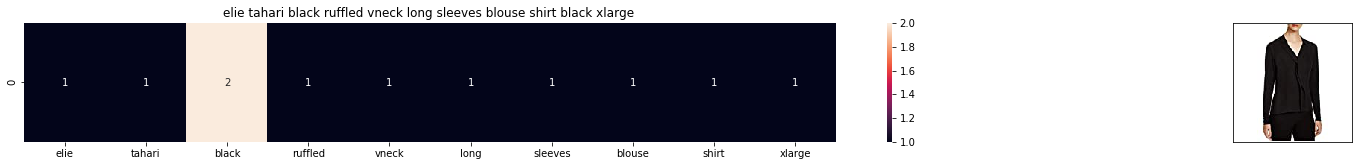

ASIN : B0728DT431
Brand: Elie Tahari
Title: elie tahari black ruffled vneck long sleeves blouse shirt black xlarge 
Euclidean similarity with the query image : 0.0


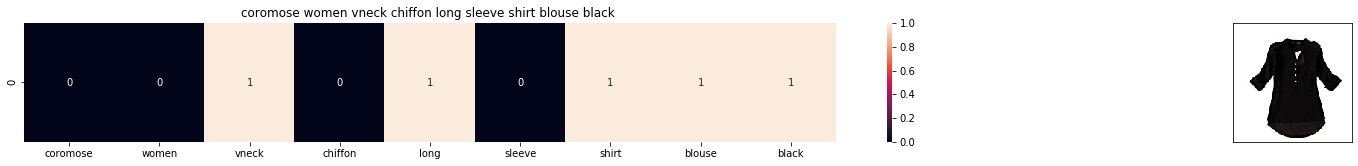

ASIN : B00NNFP22K
Brand: coromose
Title: coromose women vneck chiffon long sleeve shirt blouse black 
Euclidean similarity with the query image : 3.1622776601683795


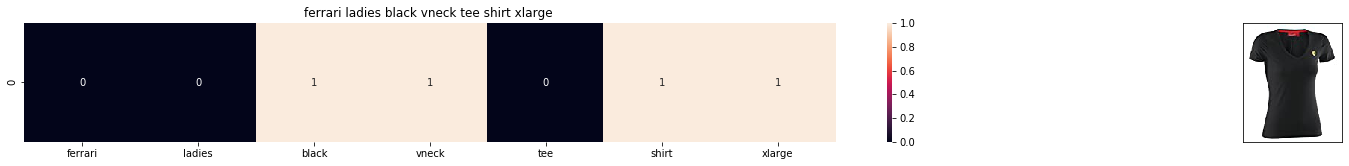

ASIN : B01EZ6XKR4
Brand: Ferrari
Title: ferrari ladies black vneck tee shirt xlarge 
Euclidean similarity with the query image : 3.1622776601683795


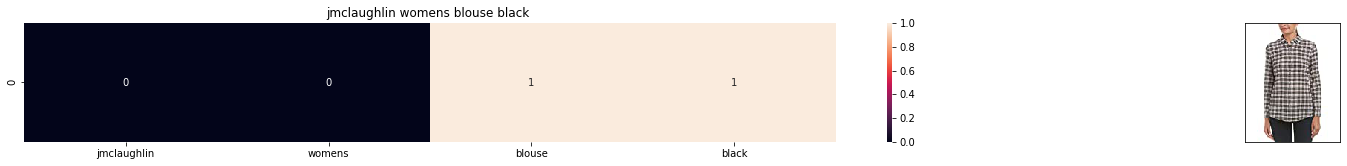

ASIN : B074KN55WS
Brand: J. McLaughlin
Title: jmclaughlin womens blouse black 
Euclidean similarity with the query image : 3.3166247903554


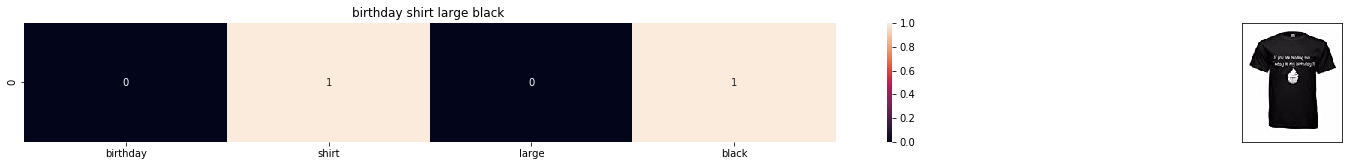

ASIN : B06XQ5V17Z
Brand: Speak Your Piece
Title: birthday shirt large black 
Euclidean similarity with the query image : 3.3166247903554


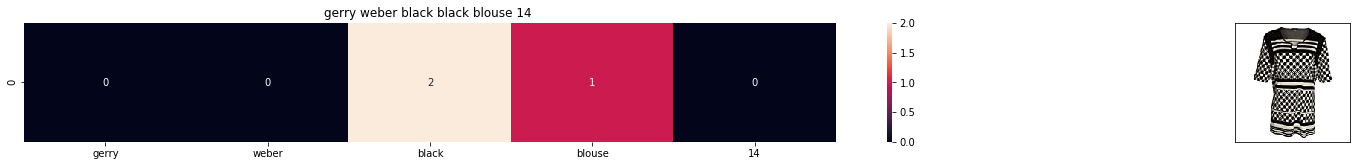

ASIN : B00O492QMI
Brand: Gerry Webber
Title: gerry weber black black blouse 14 
Euclidean similarity with the query image : 3.3166247903554


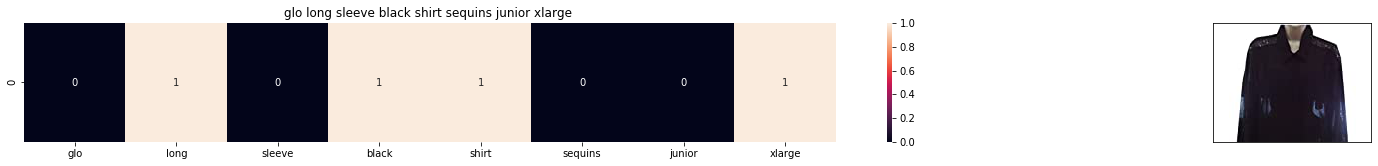

ASIN : B01NBLNC7J
Brand: Glo
Title: glo long sleeve black shirt sequins junior xlarge 
Euclidean similarity with the query image : 3.3166247903554


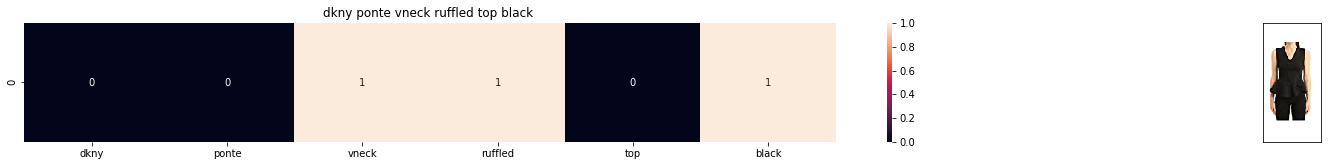

ASIN : B06XH7HQ2T
Brand: DKNY
Title: dkny ponte vneck ruffled top black 
Euclidean similarity with the query image : 3.3166247903554


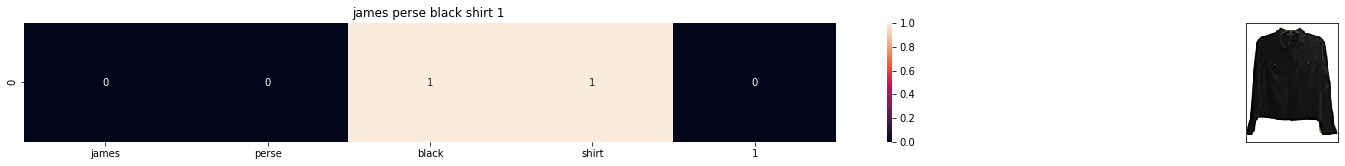

ASIN : B01N8Z2K60
Brand: James Perse
Title: james perse black shirt 1 
Euclidean similarity with the query image : 3.3166247903554


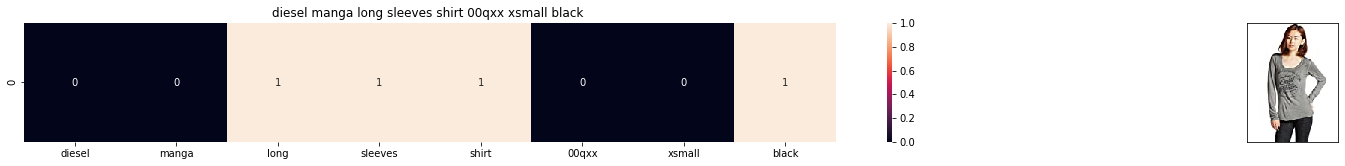

ASIN : B00N2FKJR4
Brand: DIESEL
Title: diesel manga long sleeves shirt 00qxx xsmall black 
Euclidean similarity with the query image : 3.3166247903554


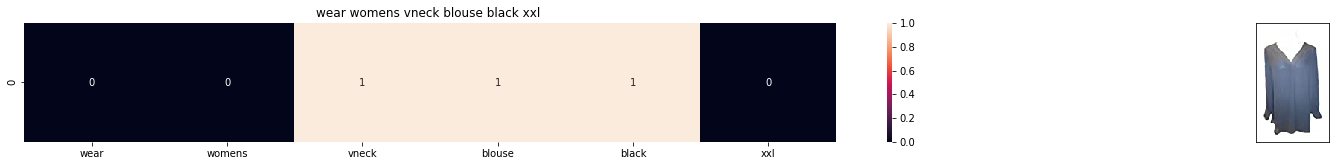

ASIN : B06Y6FH453
Brand: Who What Wear
Title: wear womens vneck blouse black xxl 
Euclidean similarity with the query image : 3.3166247903554


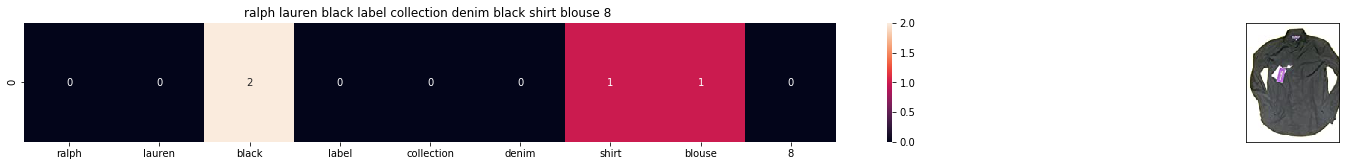

ASIN : B01EUK0EDS
Brand: Ralph Lauren Black Label
Title: ralph lauren black label collection denim black shirt blouse 8 
Euclidean similarity with the query image : 3.4641016151377544


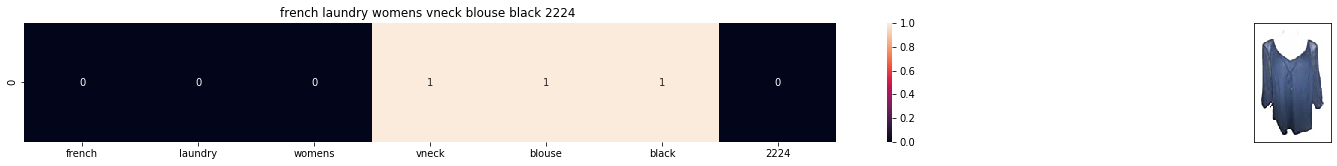

ASIN : B071Y37JDS
Brand: French Laundry
Title: french laundry womens vneck blouse black 2224 
Euclidean similarity with the query image : 3.4641016151377544


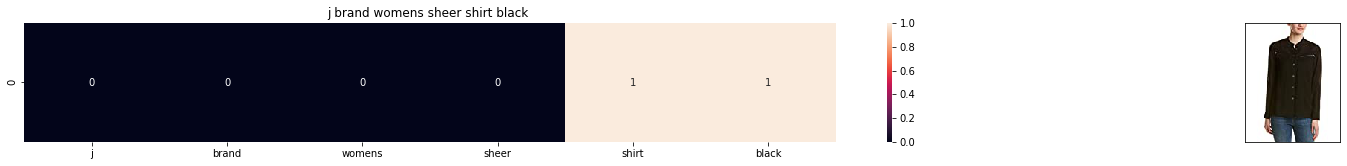

ASIN : B013L1V8PK
Brand: J Brand Jeans
Title: j brand womens sheer shirt black 
Euclidean similarity with the query image : 3.4641016151377544


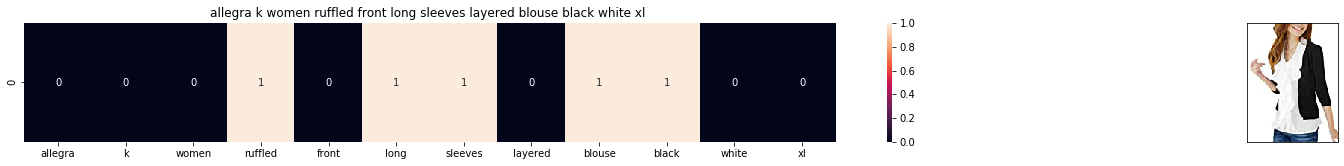

ASIN : B00E1LCYZI
Brand: Allegra K
Title: allegra k women ruffled front long sleeves layered blouse black white xl 
Euclidean similarity with the query image : 3.4641016151377544


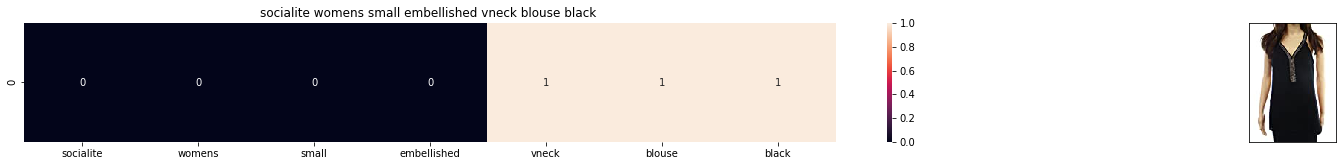

ASIN : B01K11JE9A
Brand: Socialite
Title: socialite womens small embellished vneck blouse black 
Euclidean similarity with the query image : 3.4641016151377544


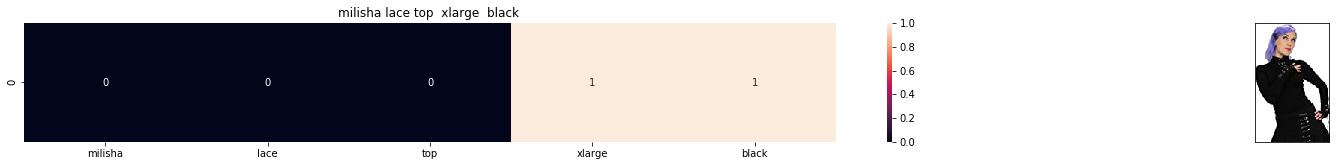

ASIN : B005AFD9WQ
Brand: Milisha
Title: milisha lace top  xlarge  black 
Euclidean similarity with the query image : 3.4641016151377544


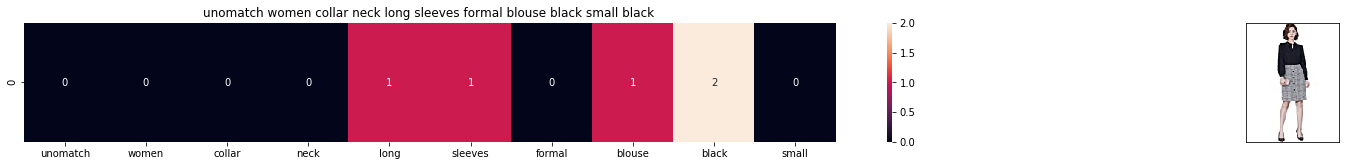

ASIN : B01N9N5VSP
Brand: Unomatch
Title: unomatch women collar neck long sleeves formal blouse black small black 
Euclidean similarity with the query image : 3.4641016151377544


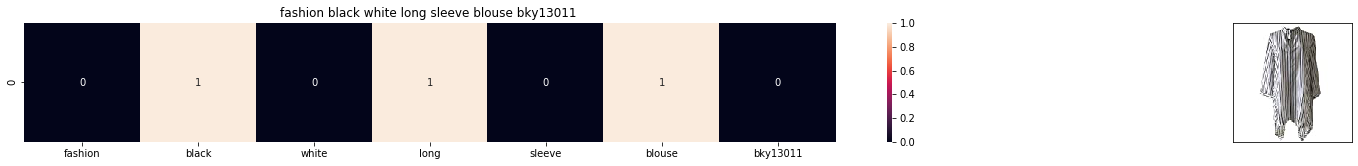

ASIN : B01FO7EI0G
Brand: bankhunyabangyai store
Title: fashion black white long sleeve blouse bky13011 
Euclidean similarity with the query image : 3.4641016151377544


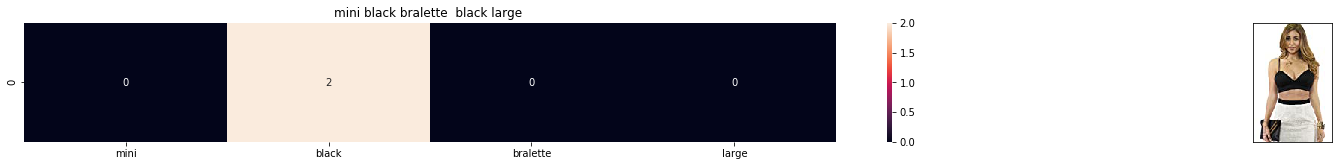

ASIN : B01HT0QG42
Brand: Lushfox
Title: mini black bralette  black large 
Euclidean similarity with the query image : 3.4641016151377544


In [44]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(12566, 20) # change the index if you want to.
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.

#try 12566
#try 931
#try 12565
#try 12562

In [45]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

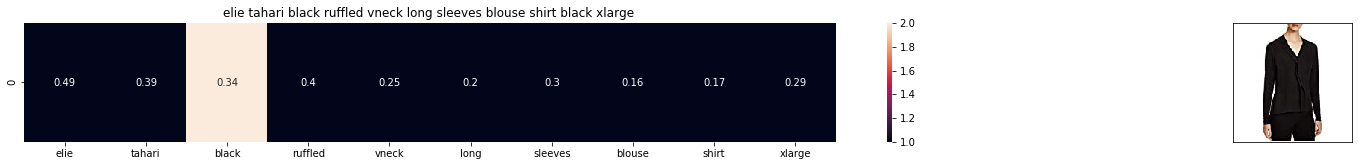

ASIN : B0728DT431
BRAND : Elie Tahari
Eucliden distance from the given image : 0.0


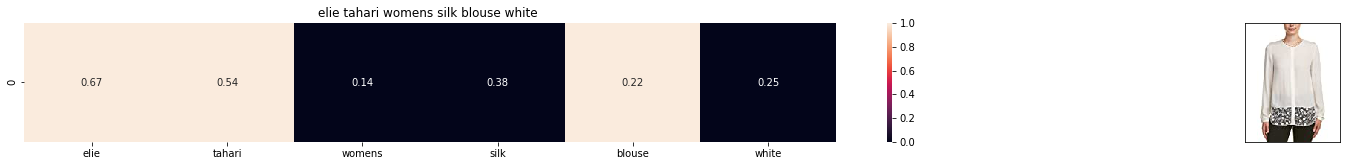

ASIN : B0758ZBV4G
BRAND : Elie Tahari
Eucliden distance from the given image : 0.930818338718771


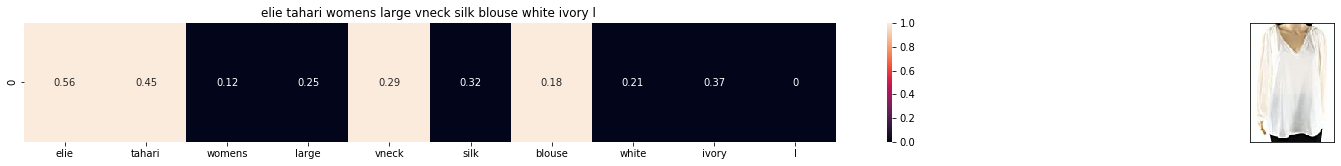

ASIN : B0758L371D
BRAND : Elie Tahari
Eucliden distance from the given image : 0.946967152190245


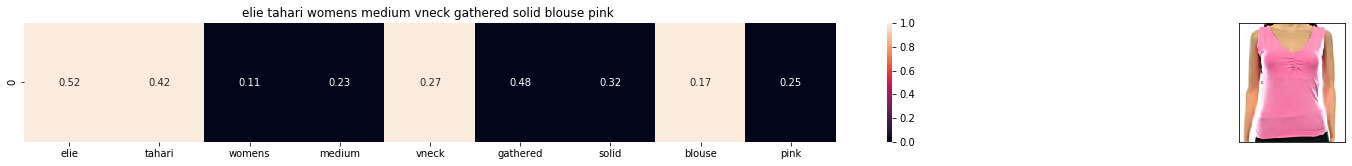

ASIN : B072VH8MKT
BRAND : Elie Tahari
Eucliden distance from the given image : 0.9917066516089336


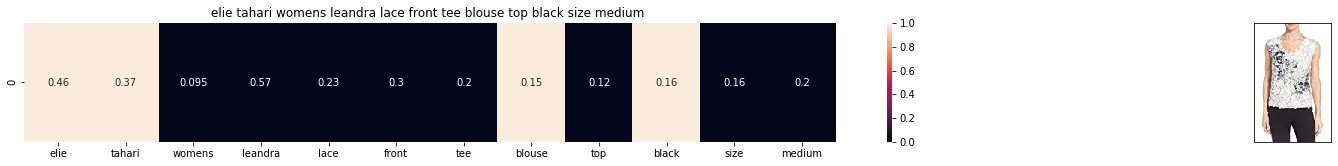

ASIN : B072HMB95W
BRAND : Elie Tahari
Eucliden distance from the given image : 1.0506076854072617


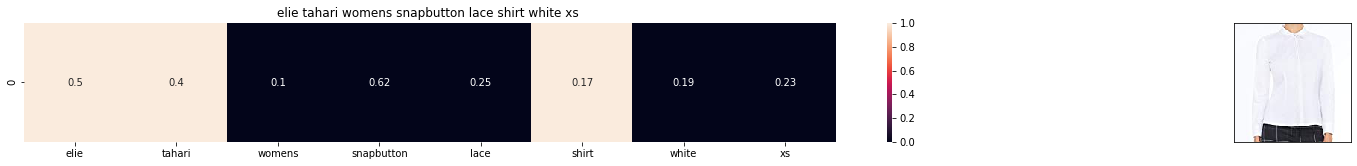

ASIN : B06X8YS632
BRAND : Elie Tahari
Eucliden distance from the given image : 1.066566411352814


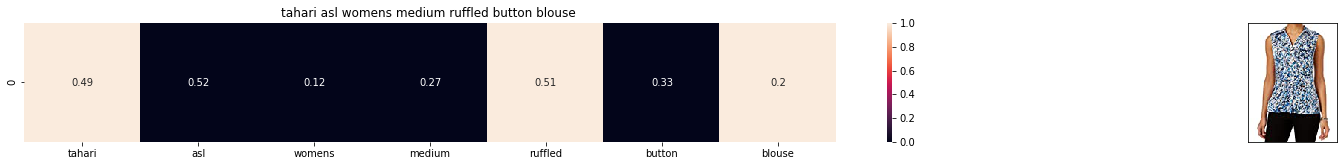

ASIN : B0727R3ZK8
BRAND : Tahari ASL
Eucliden distance from the given image : 1.0709334130469317


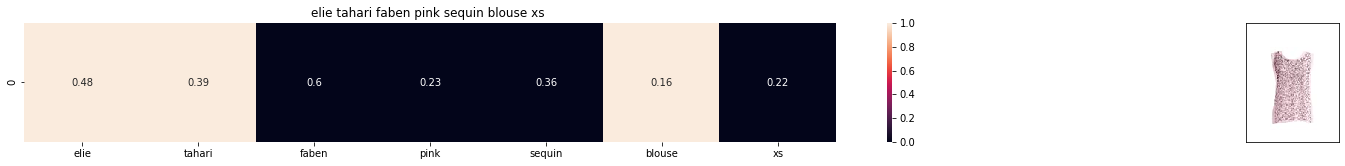

ASIN : B074VCVG5V
BRAND : Elie Tahari
Eucliden distance from the given image : 1.08545446199004


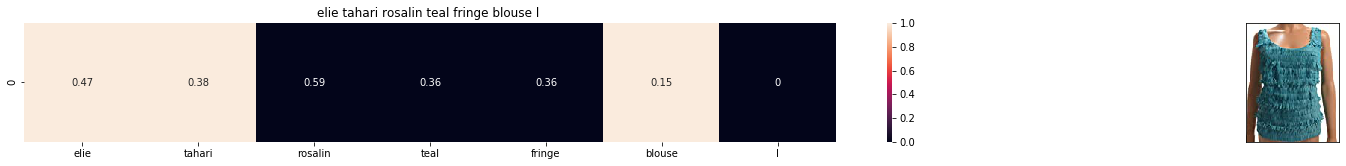

ASIN : B0751J7MJ5
BRAND : Elie Tahari
Eucliden distance from the given image : 1.092029162906729


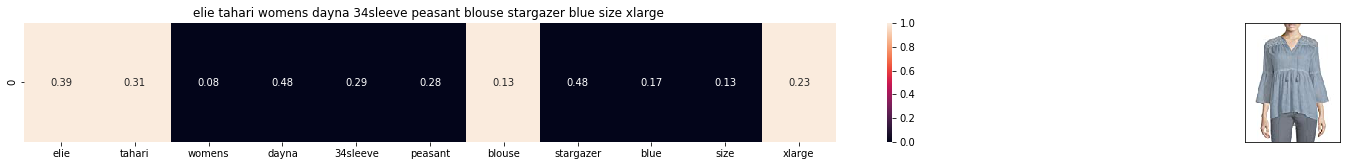

ASIN : B07258KQPD
BRAND : Elie Tahari
Eucliden distance from the given image : 1.0977009126384472


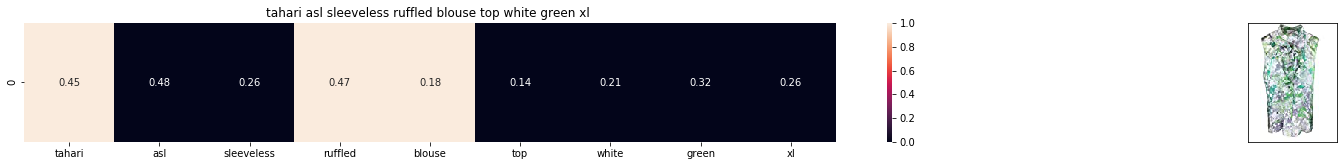

ASIN : B07196K8ZK
BRAND : Tahari ASL
Eucliden distance from the given image : 1.0978263376268496


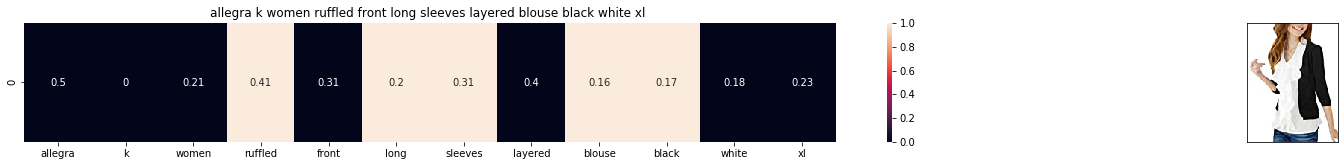

ASIN : B00E1LCYZI
BRAND : Allegra K
Eucliden distance from the given image : 1.1093679744838518


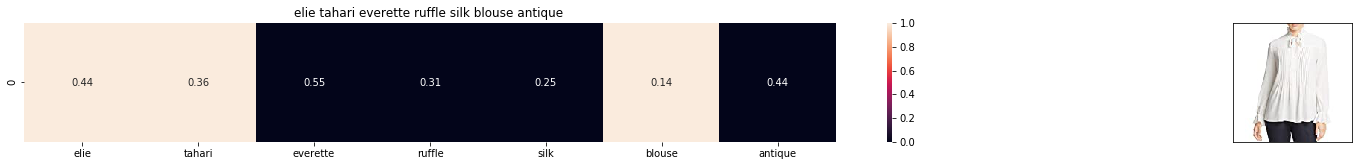

ASIN : B06XQS7B2H
BRAND : Elie Tahari
Eucliden distance from the given image : 1.1158494288000618


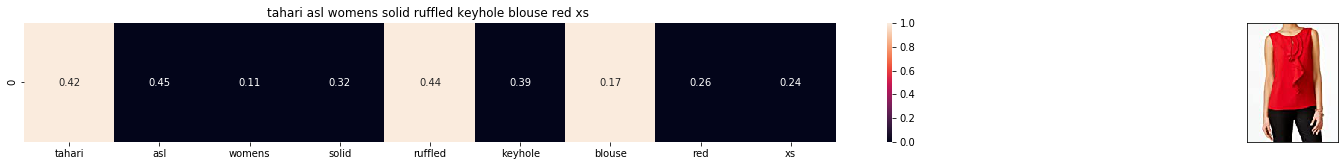

ASIN : B073DRMT4F
BRAND : Tahari ASL
Eucliden distance from the given image : 1.12308897039674


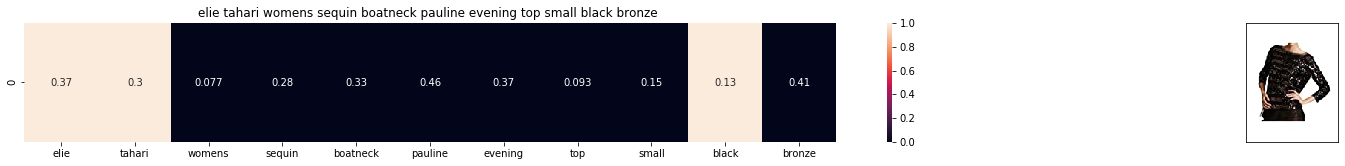

ASIN : B005E2L4XG
BRAND : Elie Tahari
Eucliden distance from the given image : 1.1459082030786756


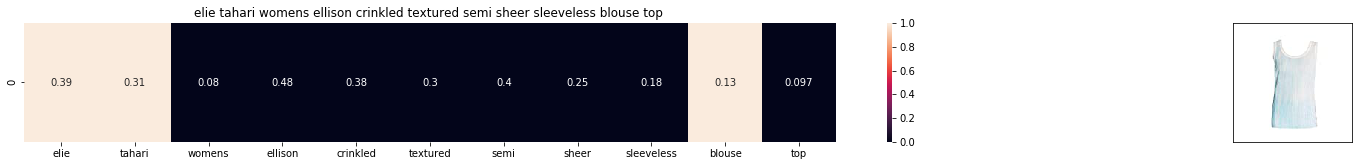

ASIN : B074VBLW5S
BRAND : Elie Tahari
Eucliden distance from the given image : 1.1581769909433588


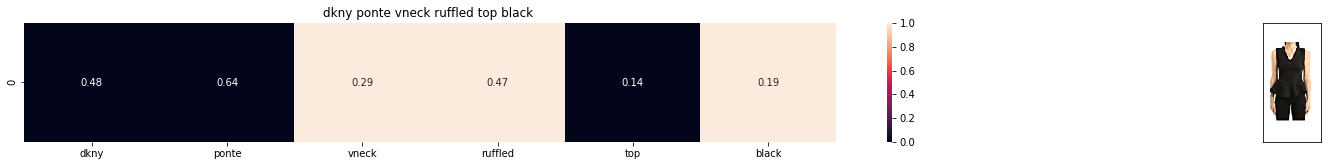

ASIN : B06XH7HQ2T
BRAND : DKNY
Eucliden distance from the given image : 1.1592903335734797


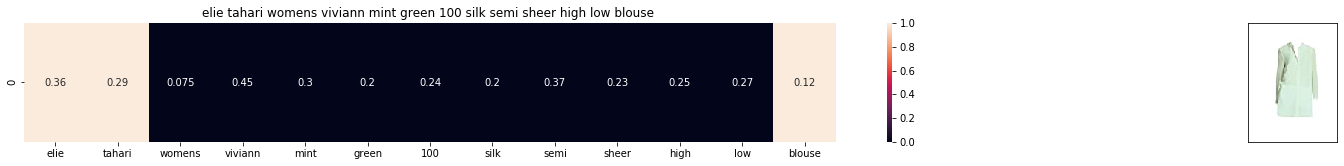

ASIN : B074VBRNX8
BRAND : Elie Tahari
Eucliden distance from the given image : 1.1758332562415978


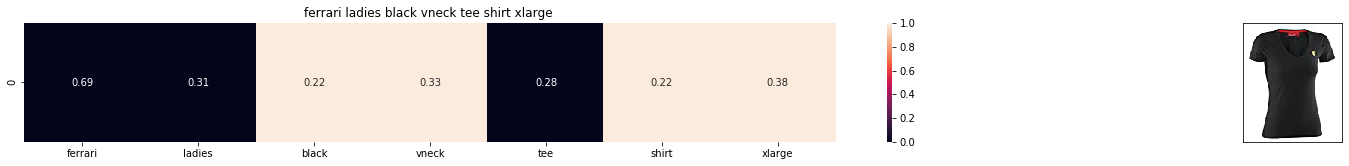

ASIN : B01EZ6XKR4
BRAND : Ferrari
Eucliden distance from the given image : 1.1773106599940453


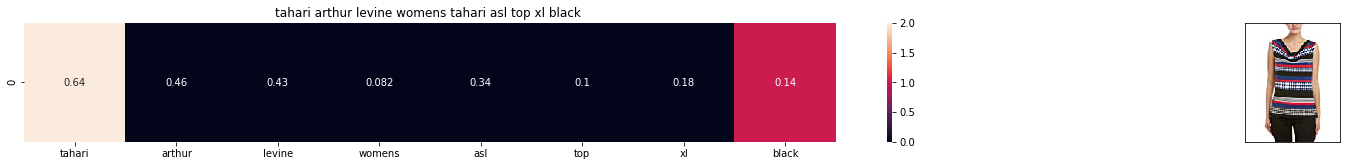

ASIN : B06X1BSY2V
BRAND : Tahari by Arthur S. Levine
Eucliden distance from the given image : 1.1849129271513121


In [46]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title

In [47]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])


In [48]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [49]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

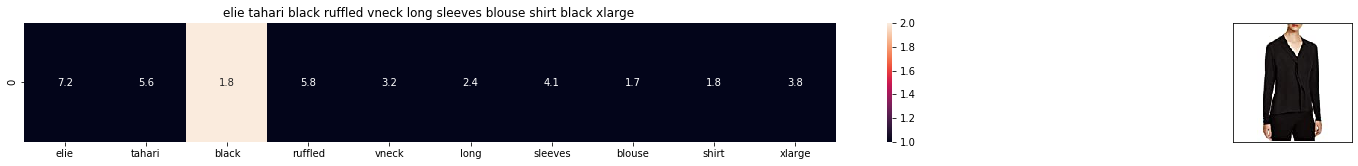

ASIN : B0728DT431
Brand : Elie Tahari
euclidean distance from the given image : 0.0


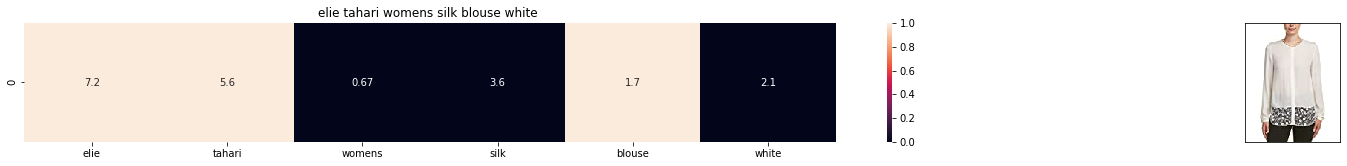

ASIN : B0758ZBV4G
Brand : Elie Tahari
euclidean distance from the given image : 10.272396151804875


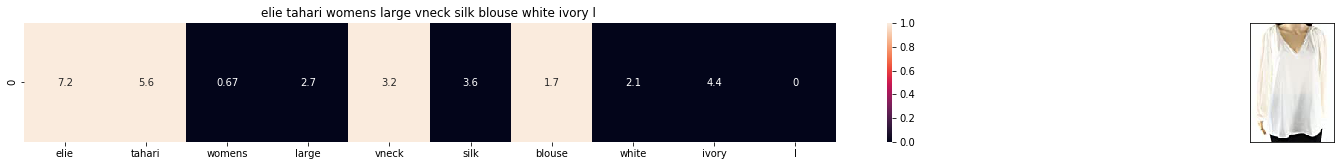

ASIN : B0758L371D
Brand : Elie Tahari
euclidean distance from the given image : 11.036534829270517


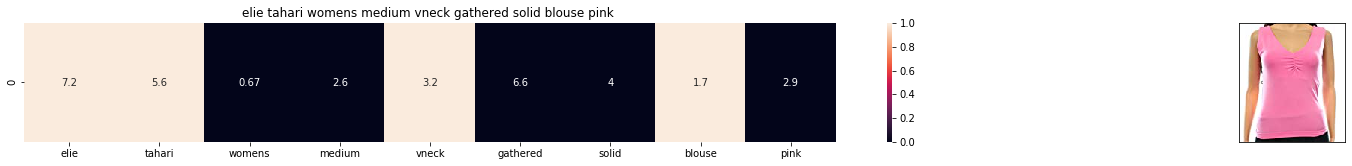

ASIN : B072VH8MKT
Brand : Elie Tahari
euclidean distance from the given image : 12.373205934247467


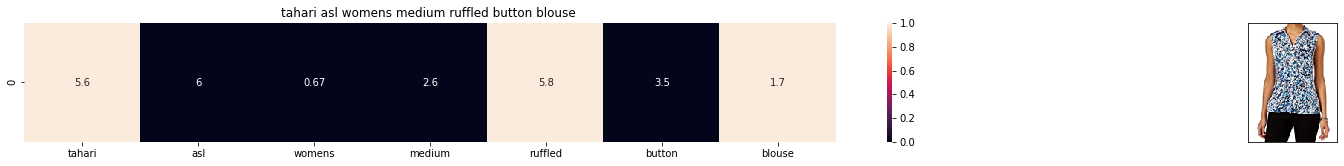

ASIN : B0727R3ZK8
Brand : Tahari ASL
euclidean distance from the given image : 12.697709298395846


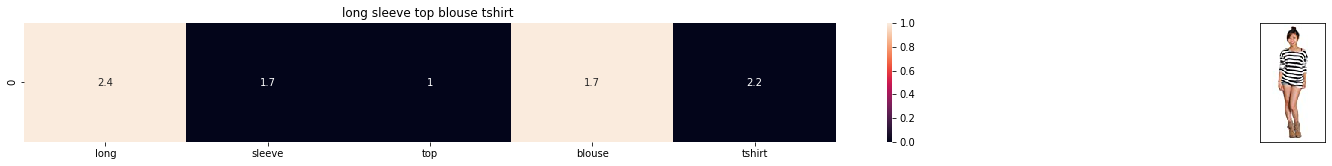

ASIN : B00KF2N5PU
Brand : Vietsbay
euclidean distance from the given image : 13.187247235872226


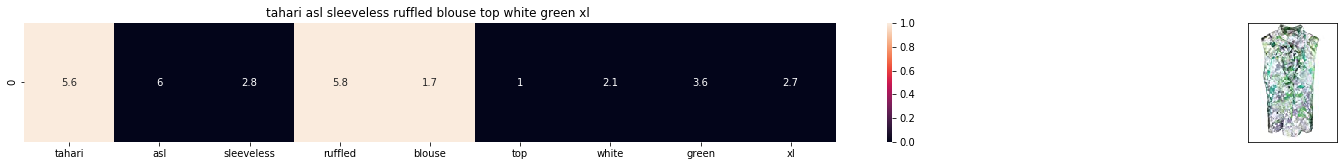

ASIN : B07196K8ZK
Brand : Tahari ASL
euclidean distance from the given image : 13.253064416683108


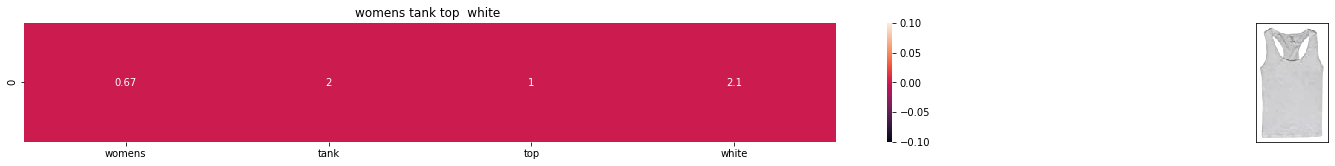

ASIN : B00JPOZ9GM
Brand : Sofra
euclidean distance from the given image : 13.534152677288542


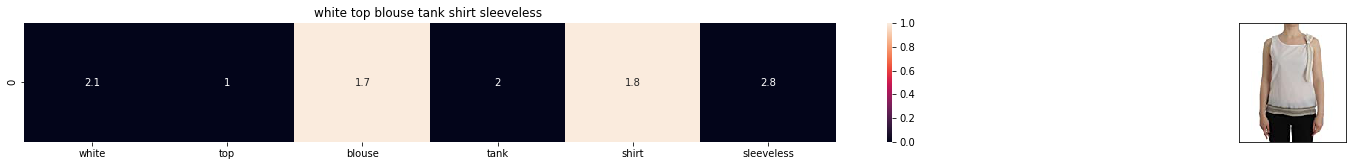

ASIN : B074G5G5RK
Brand : ERMANNO SCERVINO
euclidean distance from the given image : 13.581813575914662


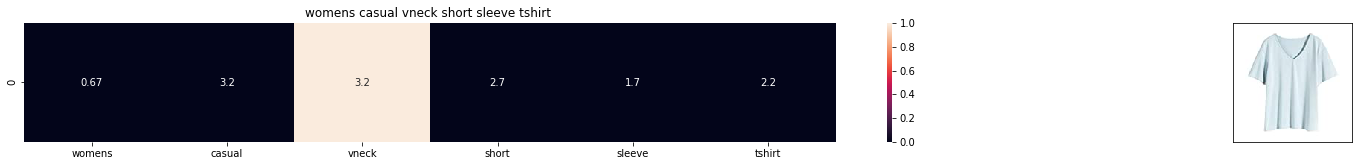

ASIN : B074V45DCX
Brand : Rain
euclidean distance from the given image : 13.732652624070516


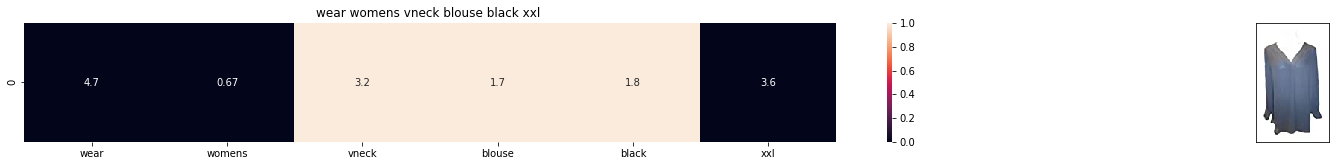

ASIN : B06Y6FH453
Brand : Who What Wear
euclidean distance from the given image : 13.866705992520554


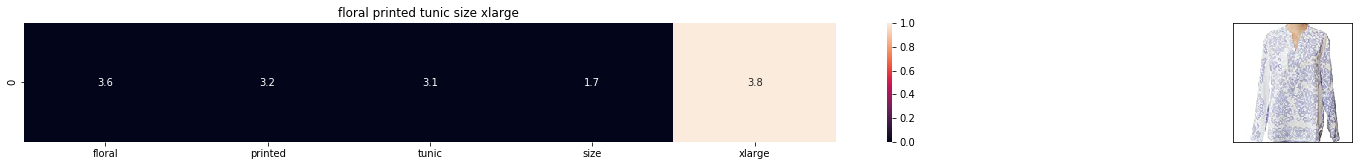

ASIN : B01GIHMP06
Brand : Amanda Blu
euclidean distance from the given image : 13.955849267184597


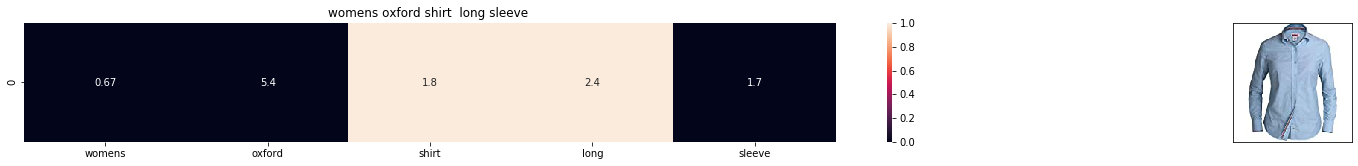

ASIN : B01577JZOC
Brand : Boast
euclidean distance from the given image : 14.033595168814491


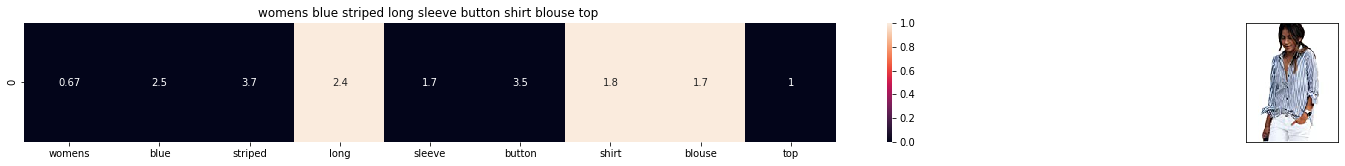

ASIN : B01KM2OLIW
Brand : Voguegirl
euclidean distance from the given image : 14.086587102456042


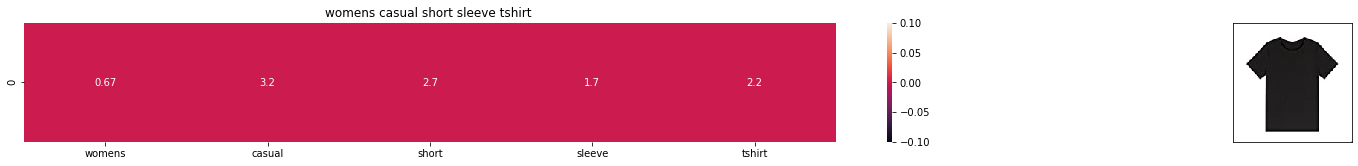

ASIN : B074T9KG9Q
Brand : Rain
euclidean distance from the given image : 14.110026927150344


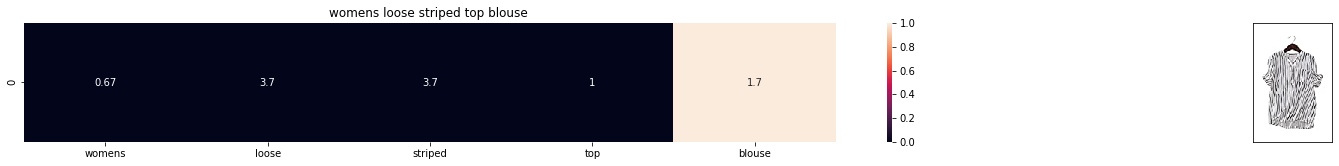

ASIN : B00ZZMYBRG
Brand : HP-LEISURE
euclidean distance from the given image : 14.150685344938193


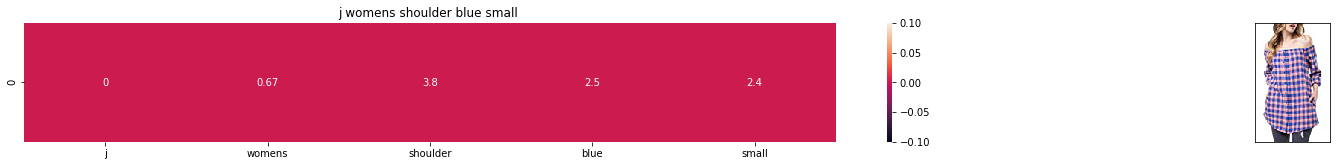

ASIN : B07583CQFT
Brand : Very J
euclidean distance from the given image : 14.156811286304405


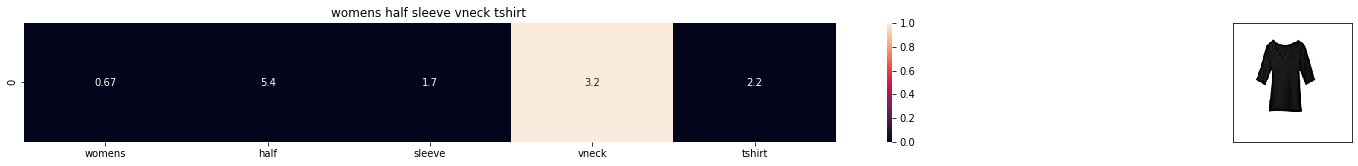

ASIN : B074W2LPYR
Brand : SNOW
euclidean distance from the given image : 14.162344641664752


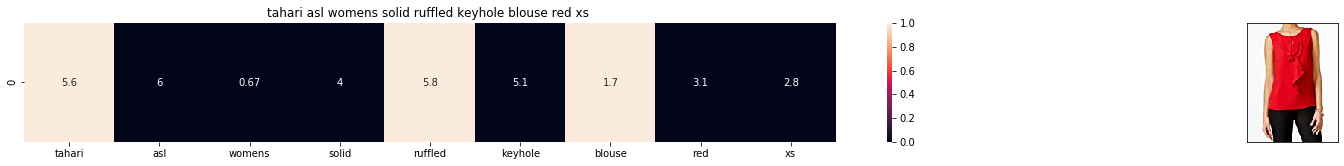

ASIN : B073DRMT4F
Brand : Tahari ASL
euclidean distance from the given image : 14.201400463392654


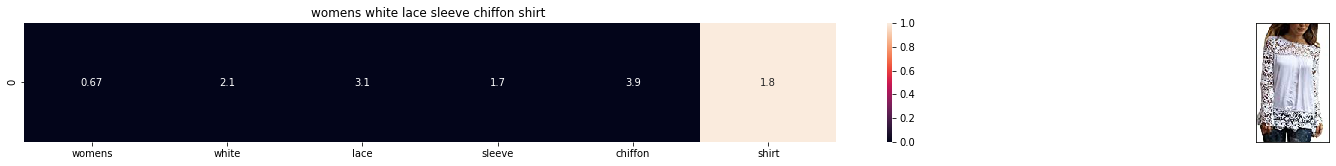

ASIN : B073JWSM1V
Brand : Fuming
euclidean distance from the given image : 14.23019494609211


In [50]:
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(12566,20)
# in the output heat map each value represents the idf values of the label word, the color represents the intersection with inputs title

In [53]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

'''
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
'''

#if you do NOT have RAM >= 12GB, use the code below.
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [54]:
def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [55]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [56]:
doc_id = 0
w2v_title = []
# for every title we build a avg vector representation
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)


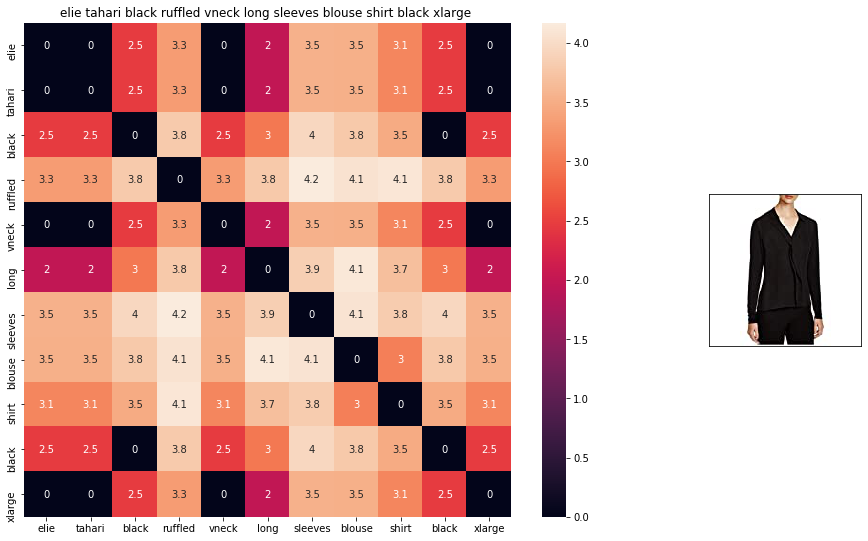

ASIN : B0728DT431
BRAND : Elie Tahari
euclidean distance from given input image : 0.0


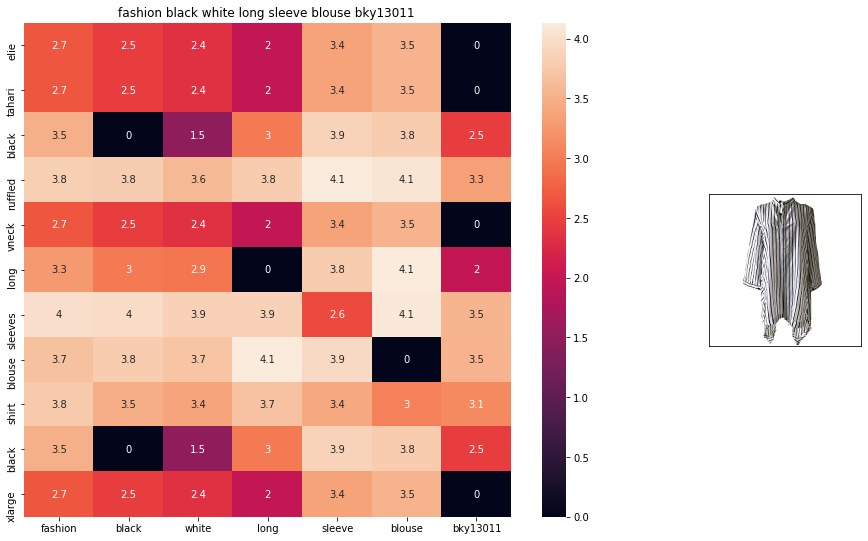

ASIN : B01FO7EI0G
BRAND : bankhunyabangyai store
euclidean distance from given input image : 0.59359294


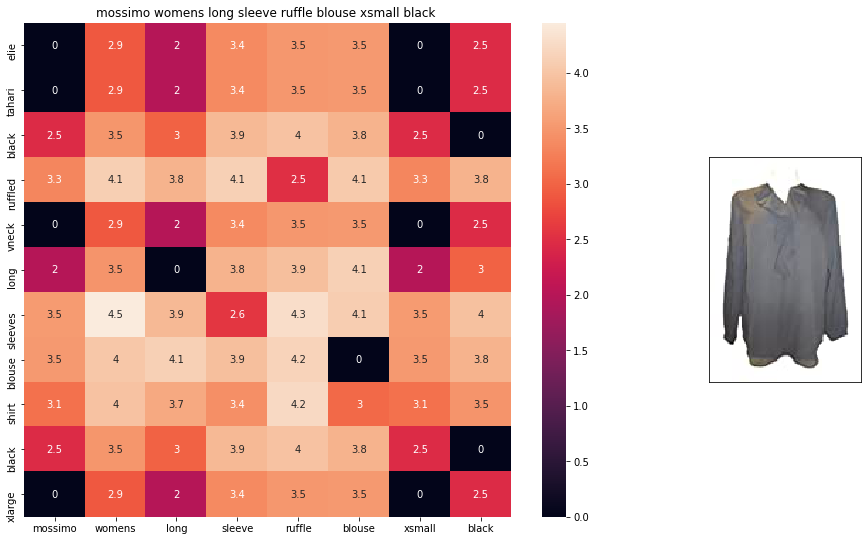

ASIN : B072BGHT28
BRAND : Mossimo
euclidean distance from given input image : 0.59382635


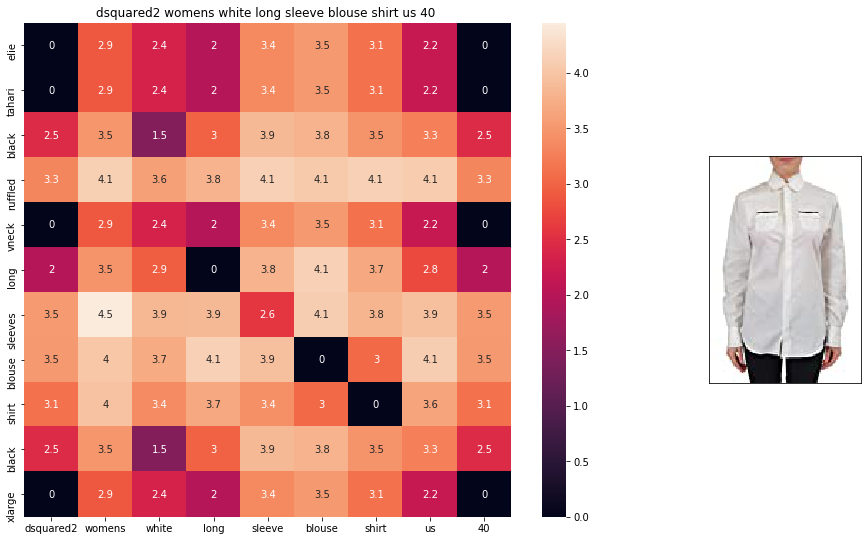

ASIN : B01758P216
BRAND : DSQUARED2
euclidean distance from given input image : 0.6099319


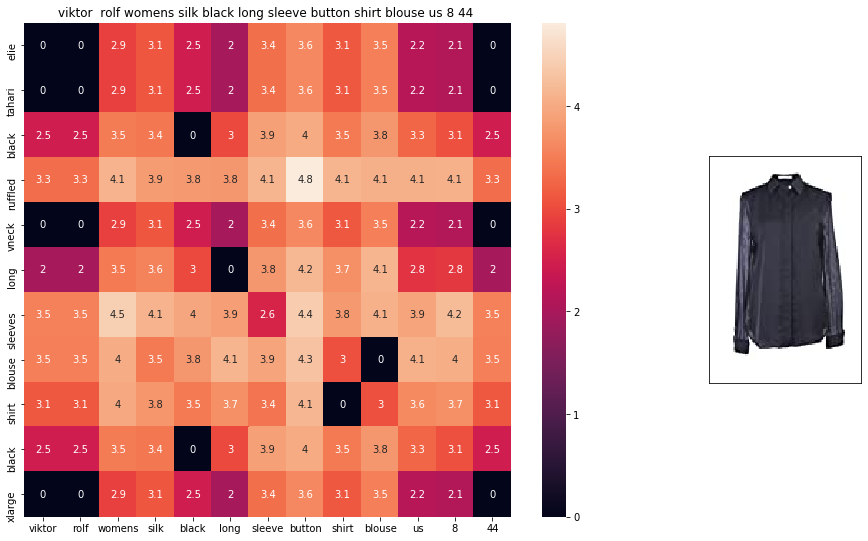

ASIN : B00N1XS6GS
BRAND : Viktor & Rolf
euclidean distance from given input image : 0.6207698


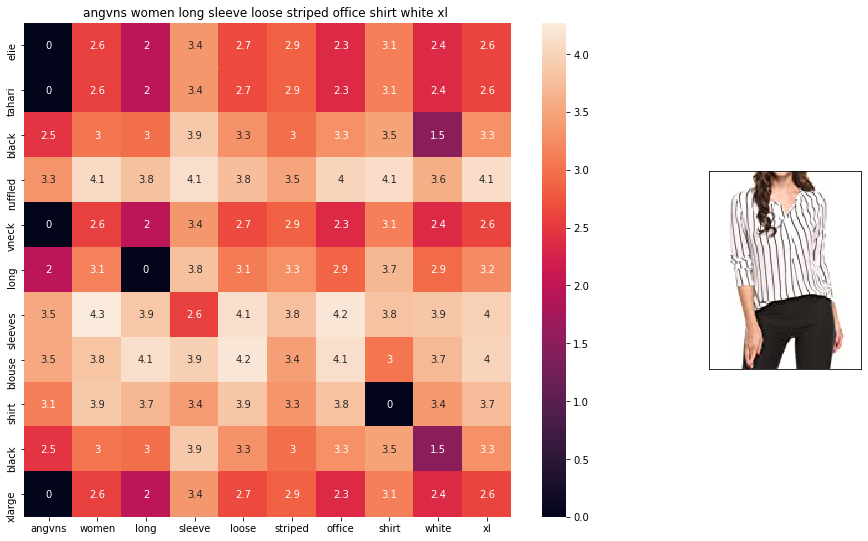

ASIN : B06XGYTQ2N
BRAND : Angvns
euclidean distance from given input image : 0.6269476


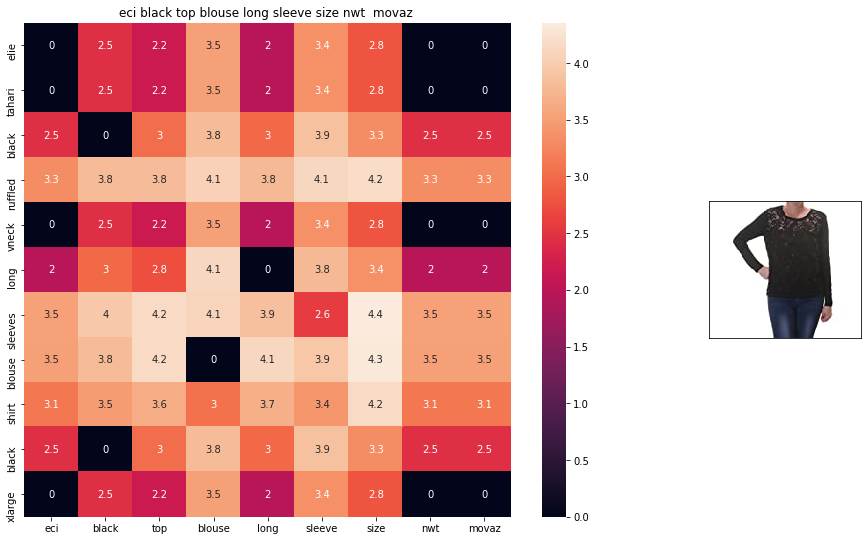

ASIN : B014LAZII8
BRAND : ECI
euclidean distance from given input image : 0.63424236


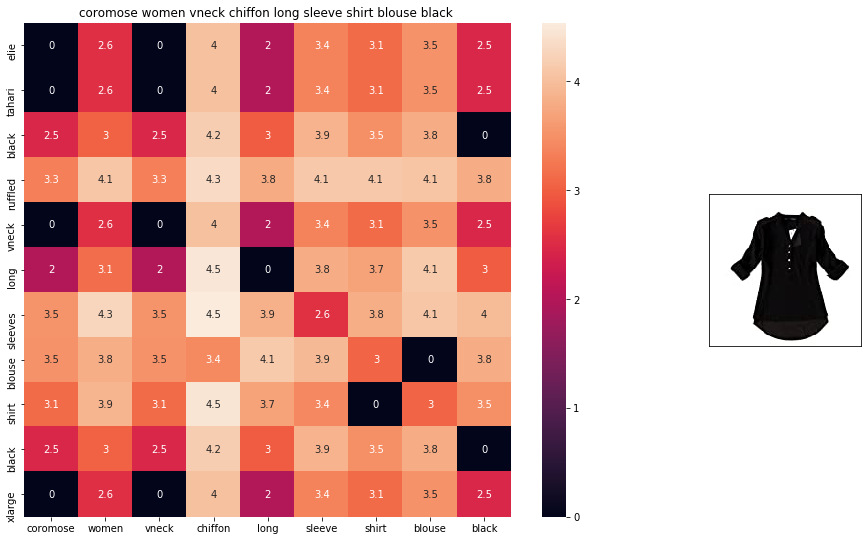

ASIN : B00NNFP22K
BRAND : coromose
euclidean distance from given input image : 0.63439375


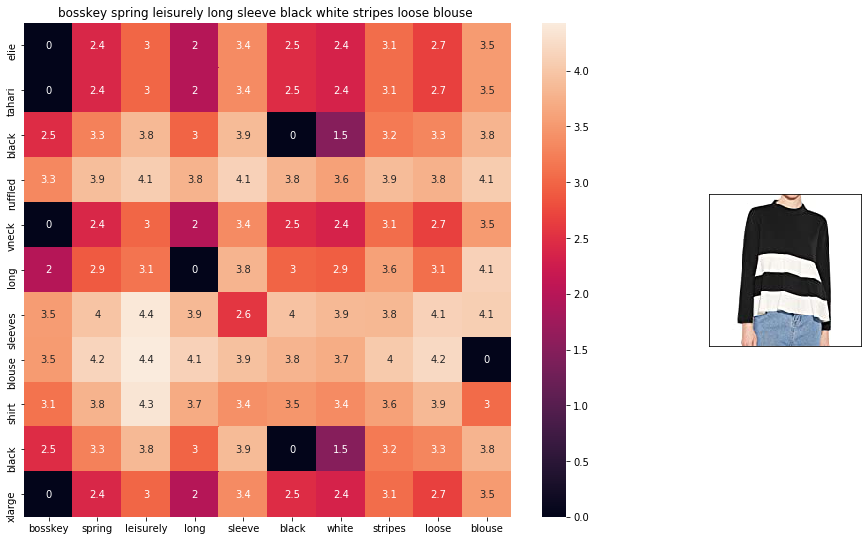

ASIN : B06XYKB2CP
BRAND : BossKey
euclidean distance from given input image : 0.6465002


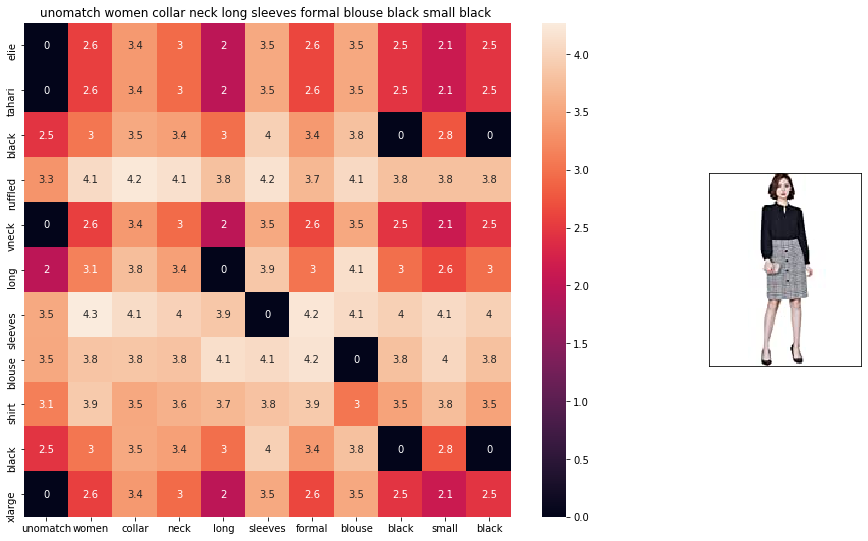

ASIN : B01N9N5VSP
BRAND : Unomatch
euclidean distance from given input image : 0.6495637


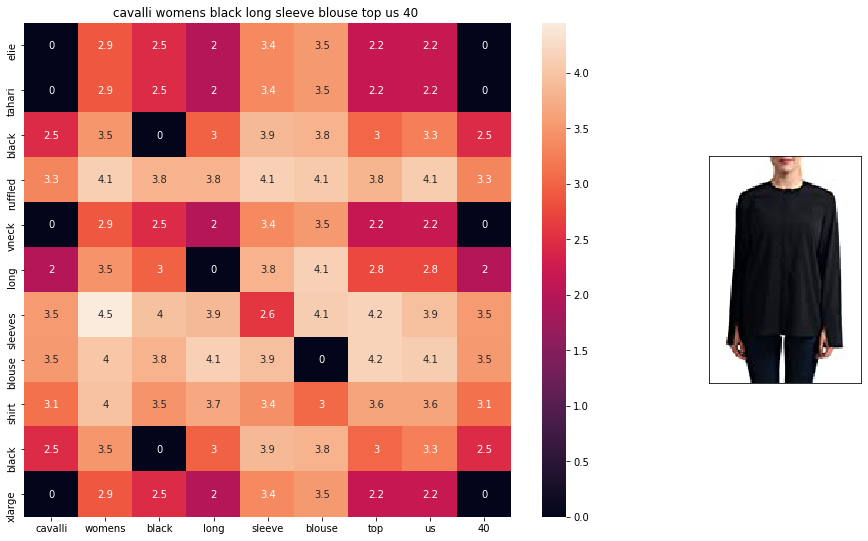

ASIN : B01BUJ6Y9U
BRAND : Just Cavalli
euclidean distance from given input image : 0.6591947


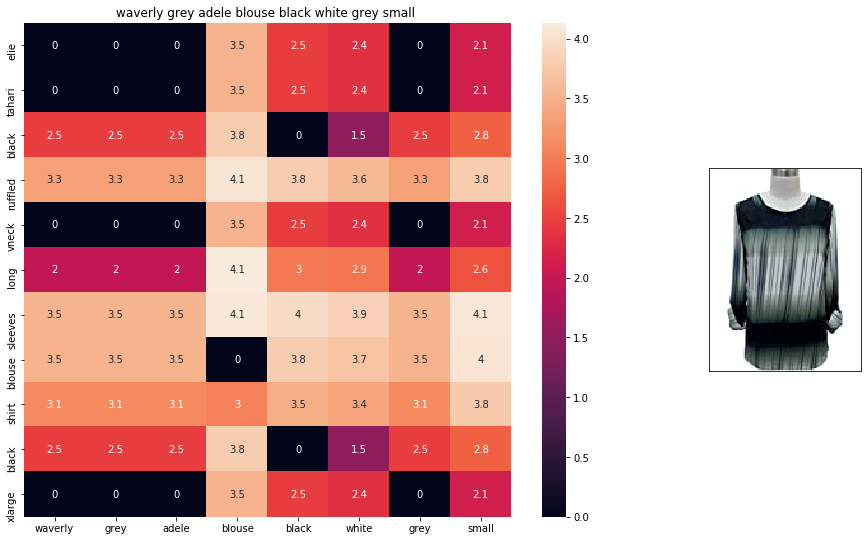

ASIN : B010C3ATDW
BRAND : Waverly Grey
euclidean distance from given input image : 0.66018945


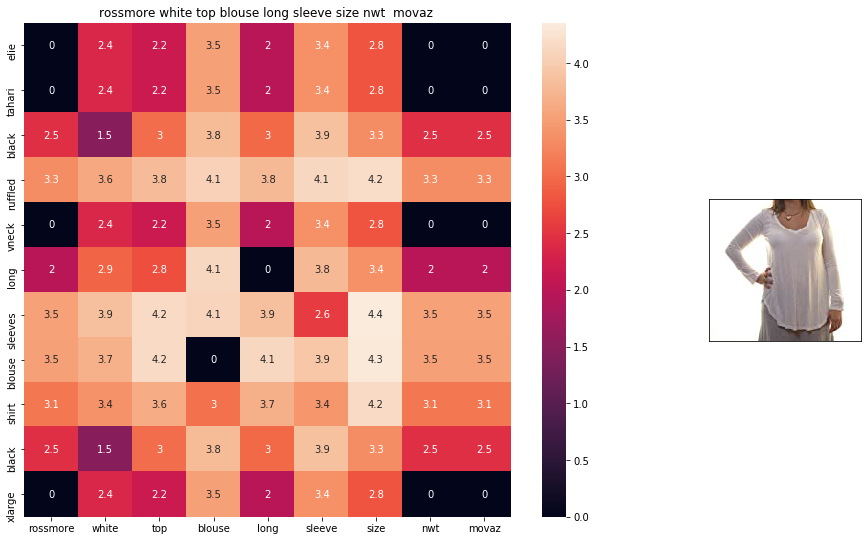

ASIN : B01KIETDV4
BRAND : Rossmore
euclidean distance from given input image : 0.6640734


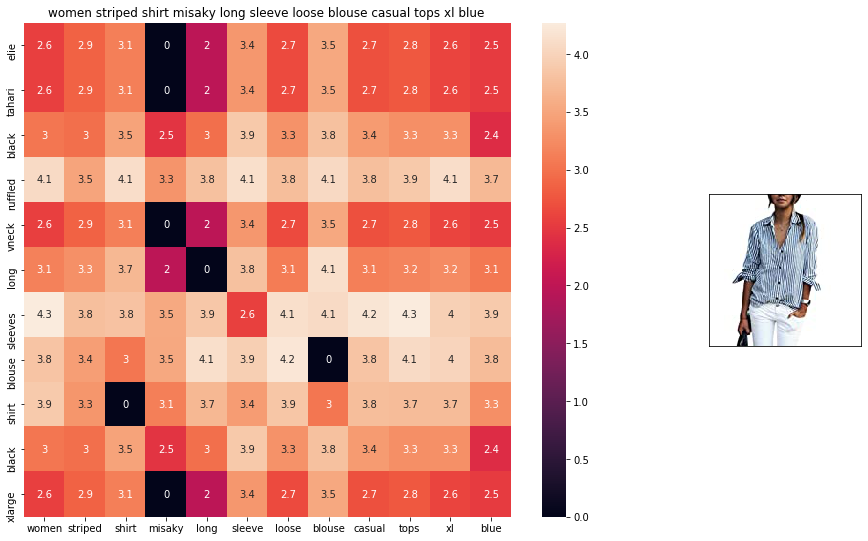

ASIN : B01L6U9CF6
BRAND : Misaky women top
euclidean distance from given input image : 0.66594446


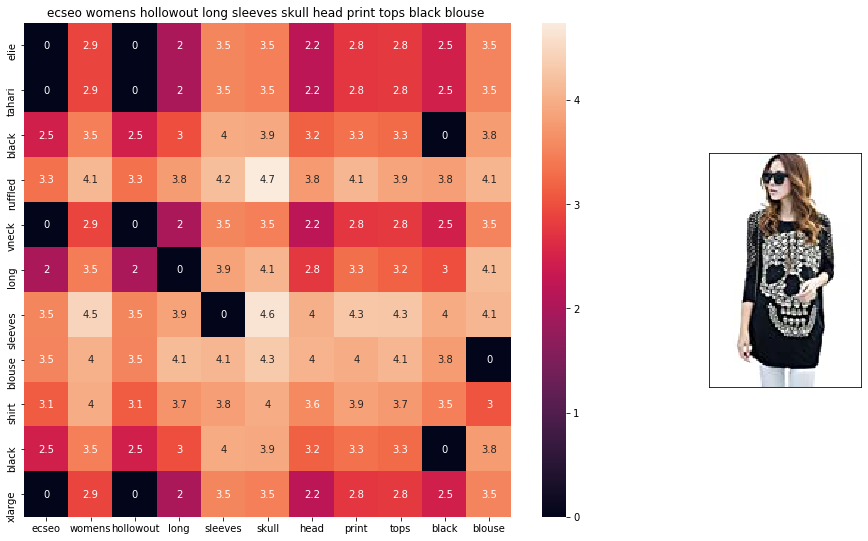

ASIN : B01M68CQ1Z
BRAND : ECSEO
euclidean distance from given input image : 0.6664554


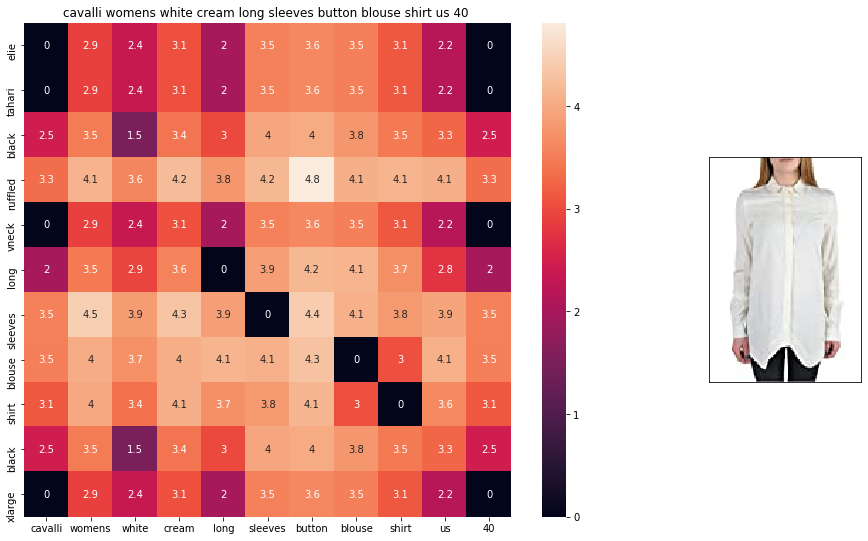

ASIN : B00U7U4NAG
BRAND : Just Cavalli
euclidean distance from given input image : 0.66650444


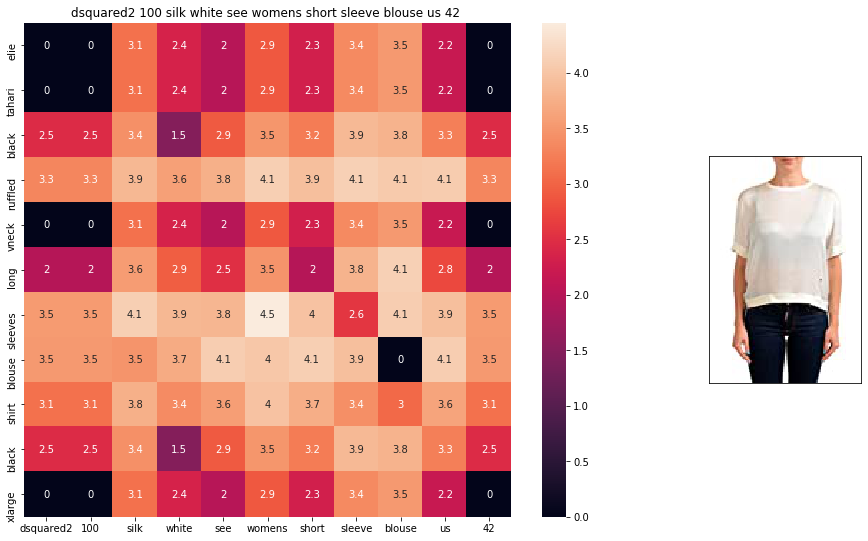

ASIN : B074FRKBC5
BRAND : DSQUARED2
euclidean distance from given input image : 0.667677


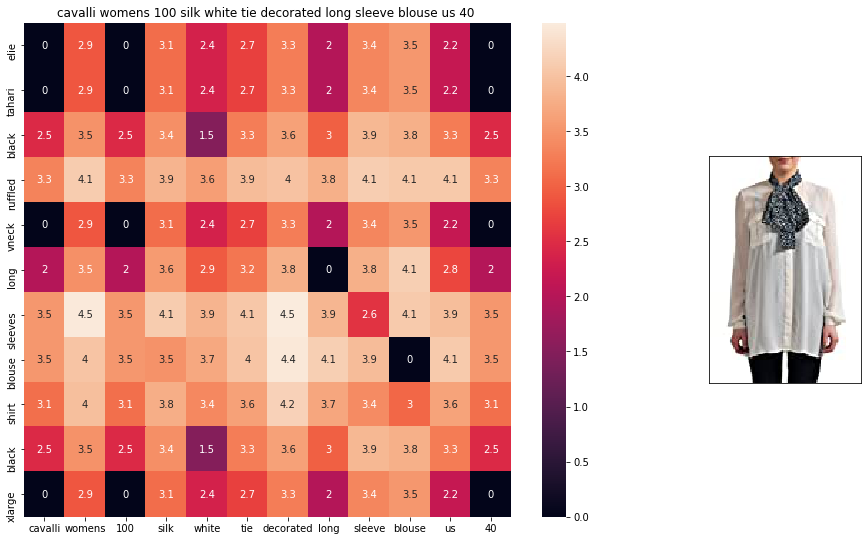

ASIN : B01BLKPXCM
BRAND : Just Cavalli
euclidean distance from given input image : 0.6699511


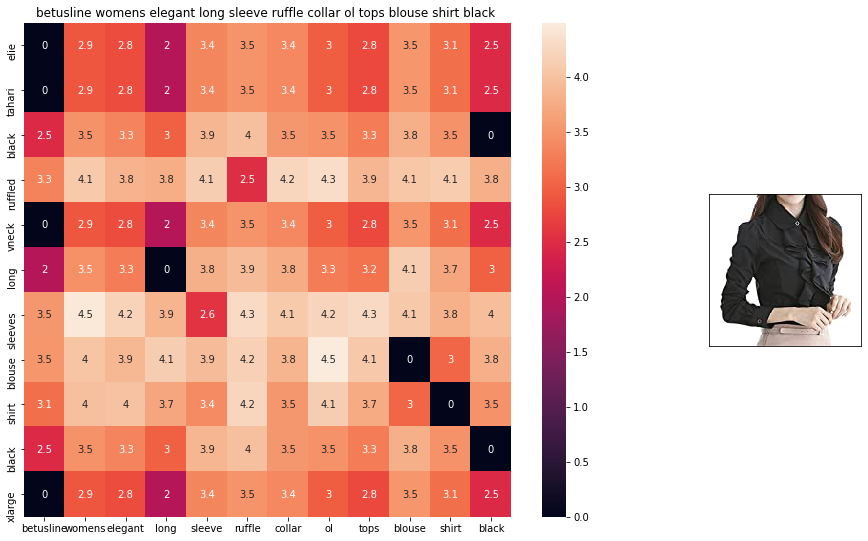

ASIN : B01M7T7BF8
BRAND : Betusline Women Clothes
euclidean distance from given input image : 0.6710753


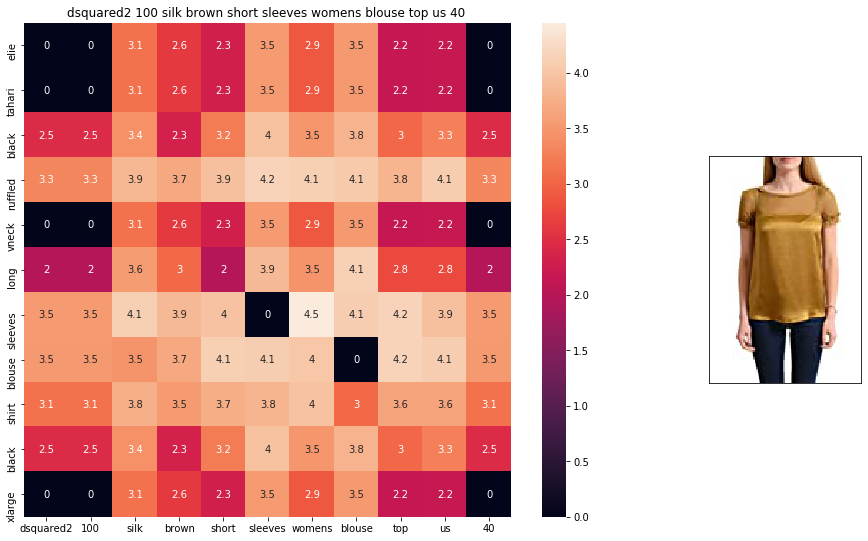

ASIN : B01D3X0DI4
BRAND : DSQUARED2
euclidean distance from given input image : 0.671687


In [57]:
def avg_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)

        
avg_w2v_model(12566, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

In [58]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

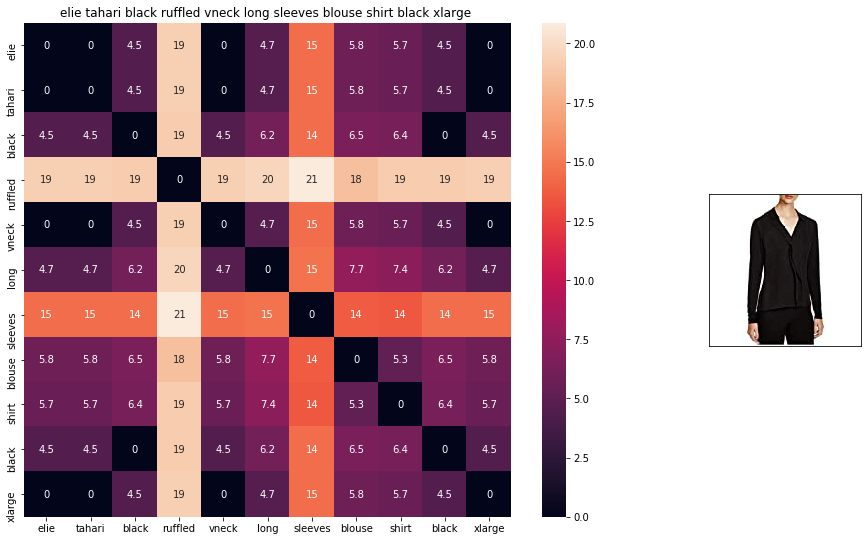

ASIN : B0728DT431
Brand : Elie Tahari
euclidean distance from input : 0.0


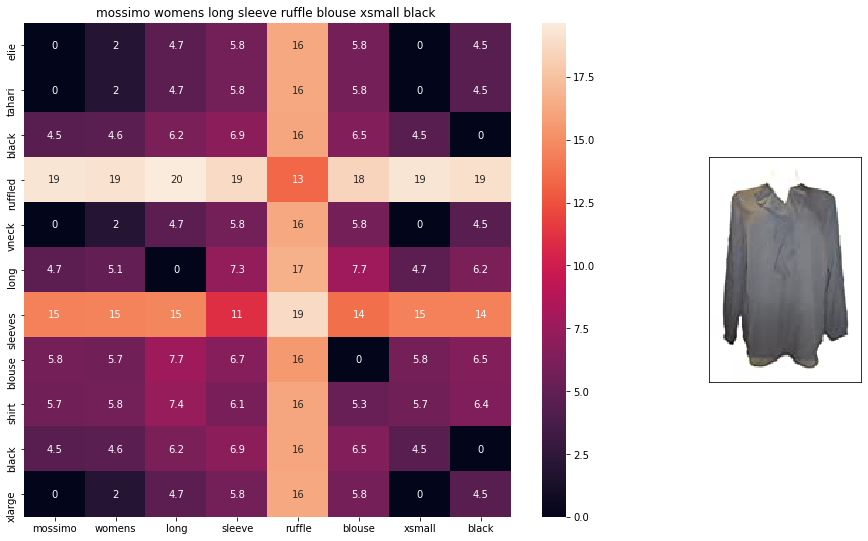

ASIN : B072BGHT28
Brand : Mossimo
euclidean distance from input : 1.8171854


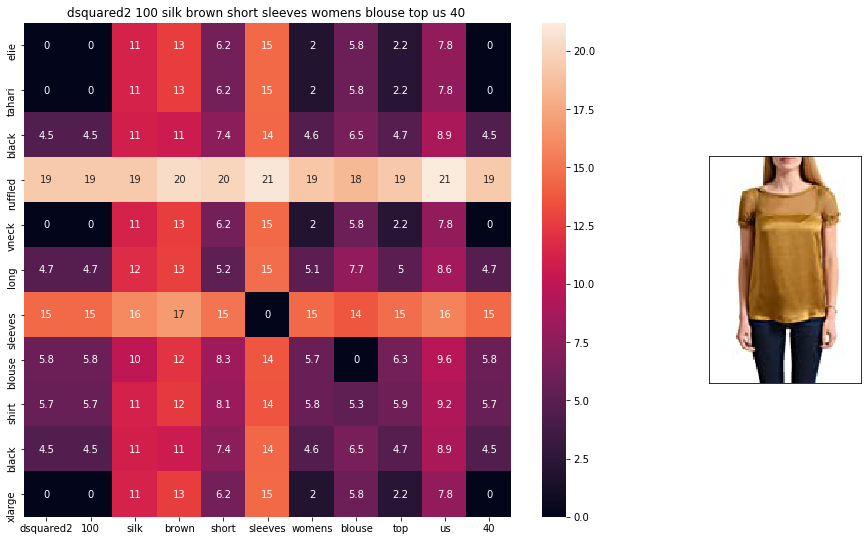

ASIN : B01D3X0DI4
Brand : DSQUARED2
euclidean distance from input : 2.170644


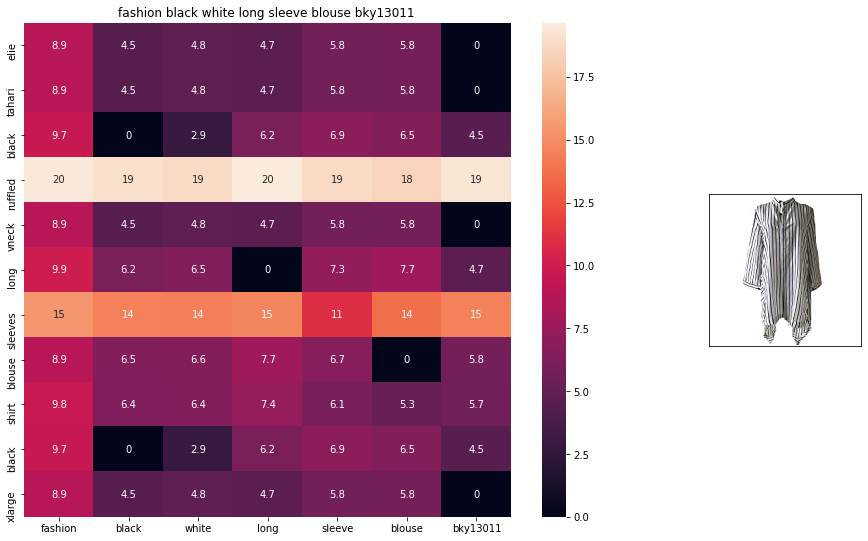

ASIN : B01FO7EI0G
Brand : bankhunyabangyai store
euclidean distance from input : 2.1719441


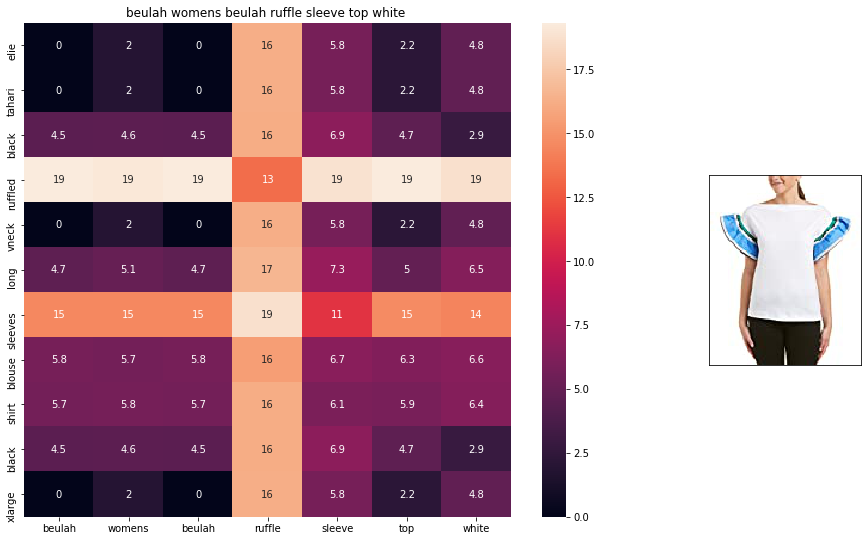

ASIN : B074DL2HQ4
Brand : Beulah
euclidean distance from input : 2.180363


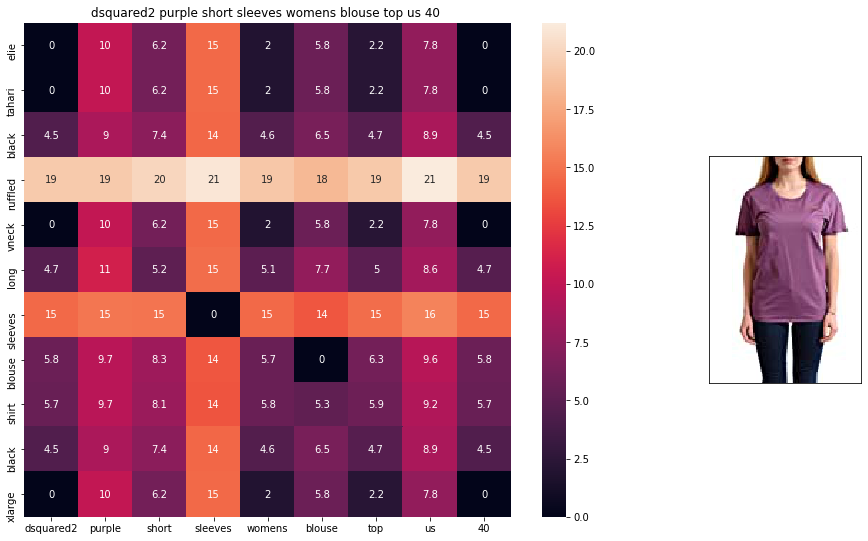

ASIN : B01D3VEIOG
Brand : DSQUARED2
euclidean distance from input : 2.193677


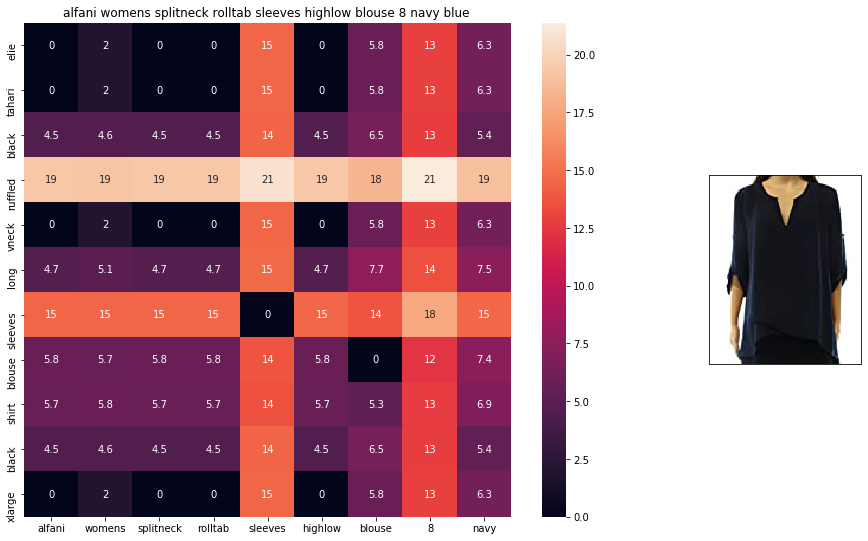

ASIN : B073WGXB97
Brand : Alfani
euclidean distance from input : 2.2116346


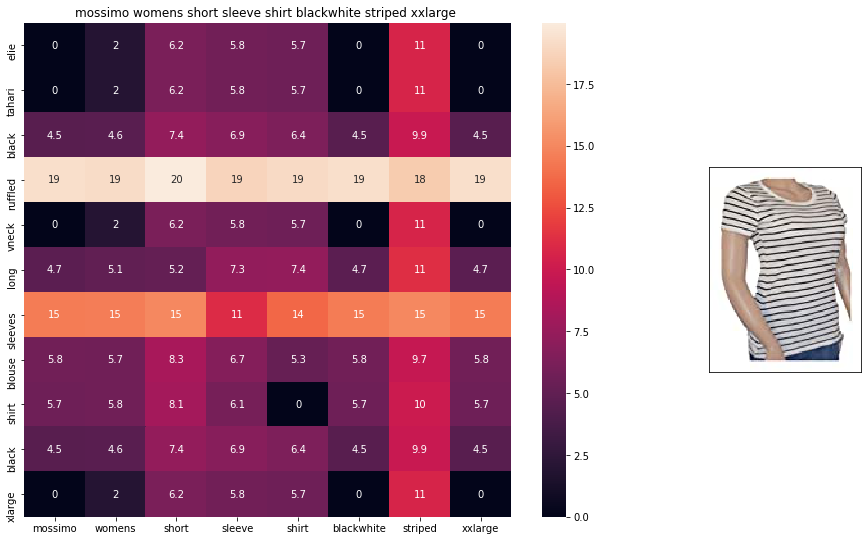

ASIN : B071VC8NYK
Brand : Mossimo
euclidean distance from input : 2.2786043


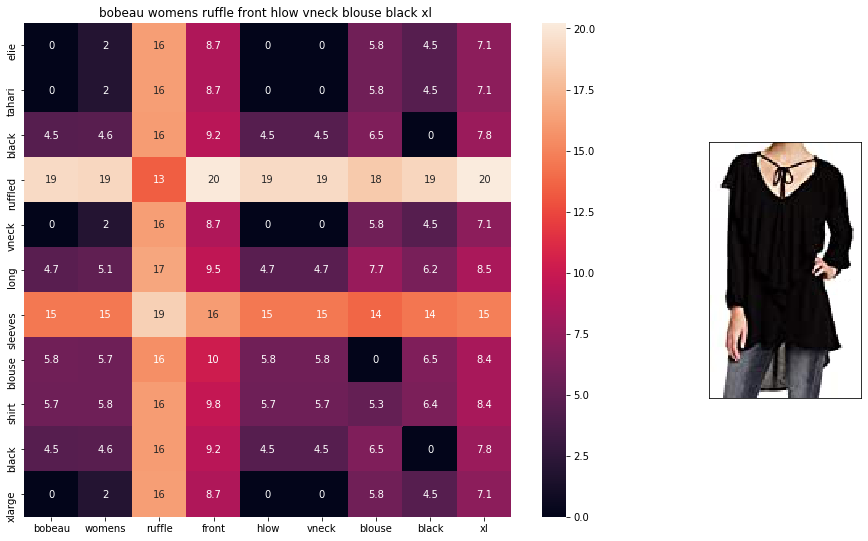

ASIN : B0758J19PY
Brand : Bobeau
euclidean distance from input : 2.302847


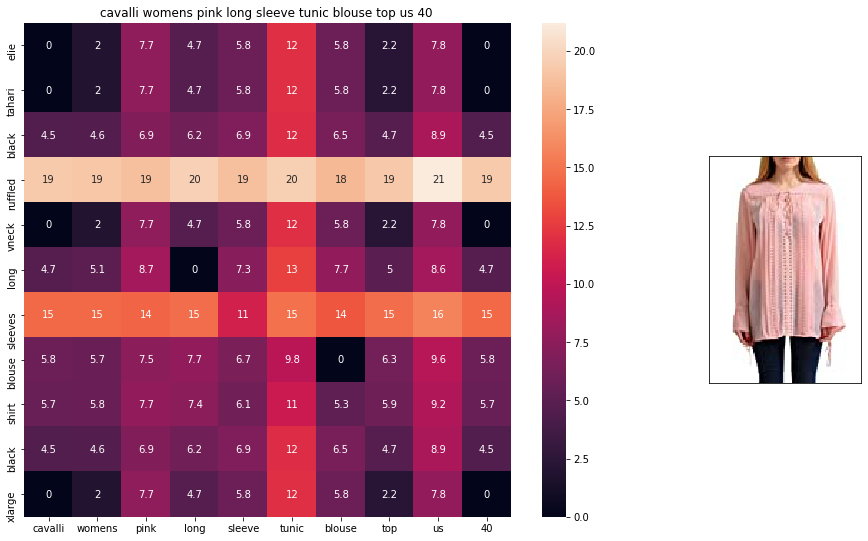

ASIN : B01CAT86UO
Brand : Just Cavalli
euclidean distance from input : 2.3259666


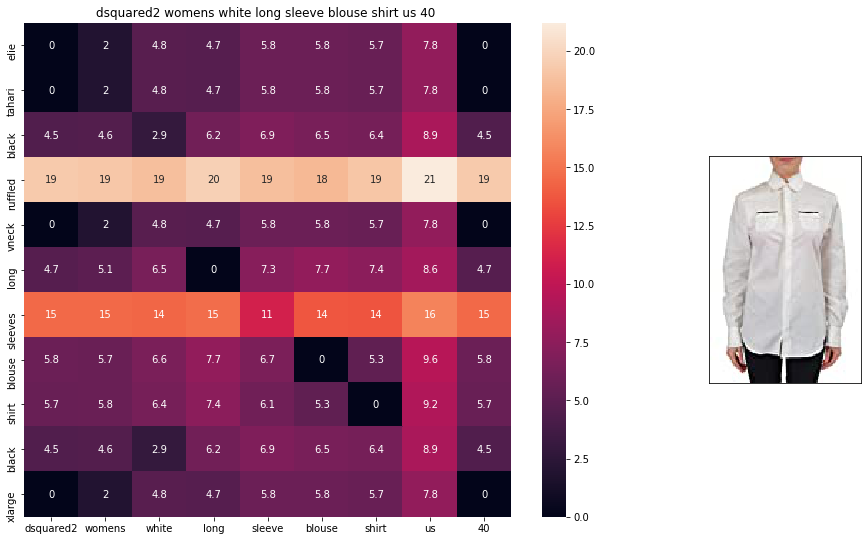

ASIN : B01758P216
Brand : DSQUARED2
euclidean distance from input : 2.326704


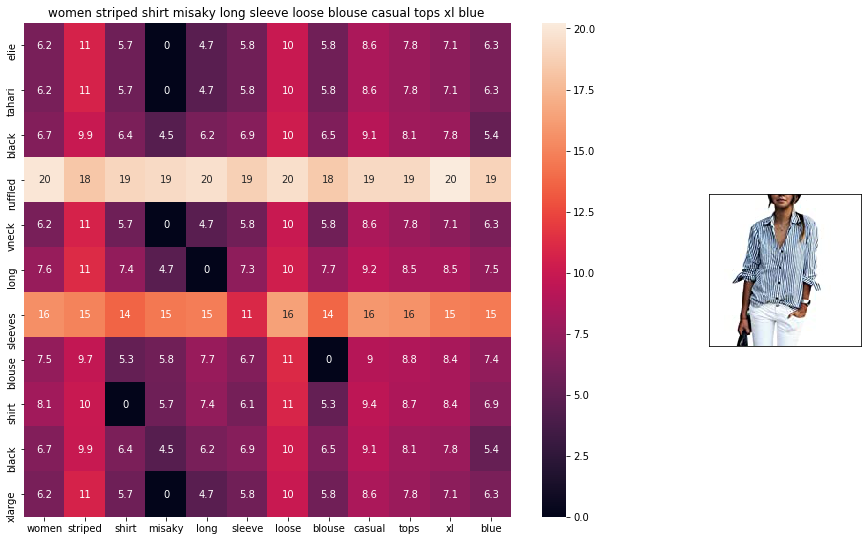

ASIN : B01L6U9CF6
Brand : Misaky women top
euclidean distance from input : 2.3278623


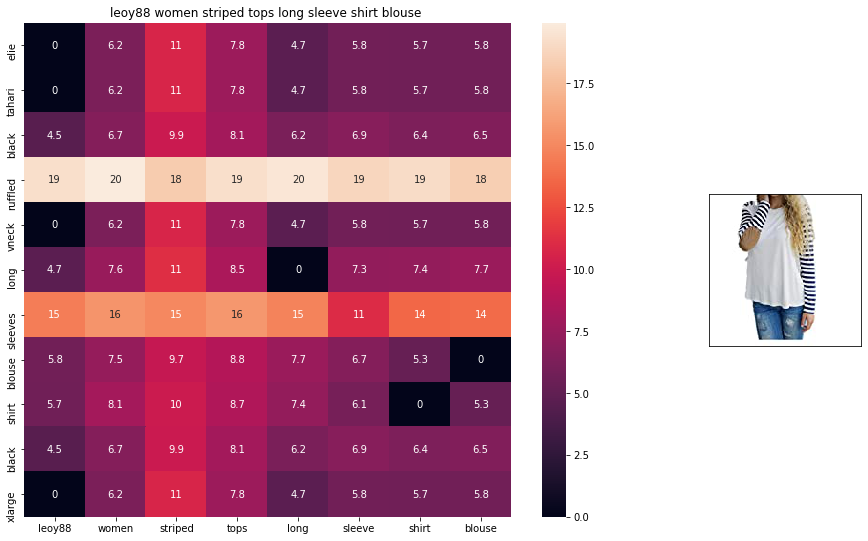

ASIN : B01MCTJA7J
Brand : Leoy88 Women Blouse
euclidean distance from input : 2.3499706


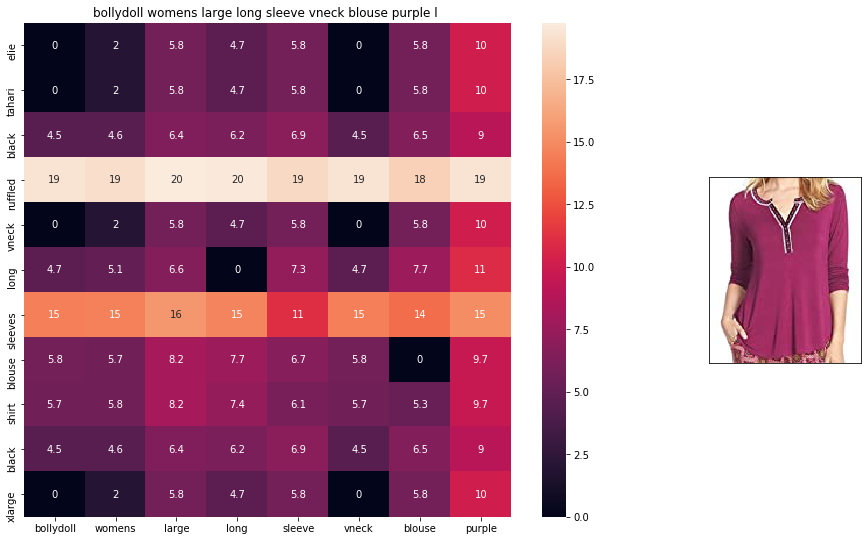

ASIN : B074MJPLCB
Brand : BollyDoll
euclidean distance from input : 2.3507879


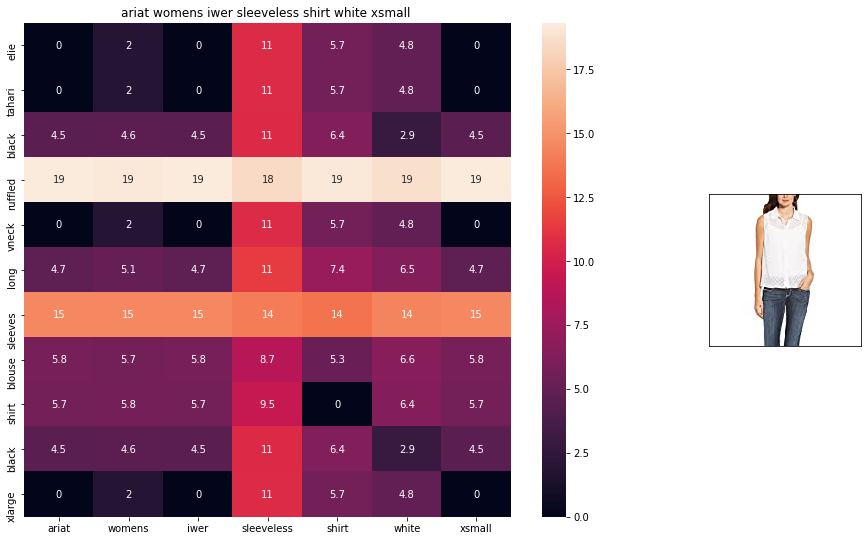

ASIN : B073MPXPY3
Brand : Ariat
euclidean distance from input : 2.3590605


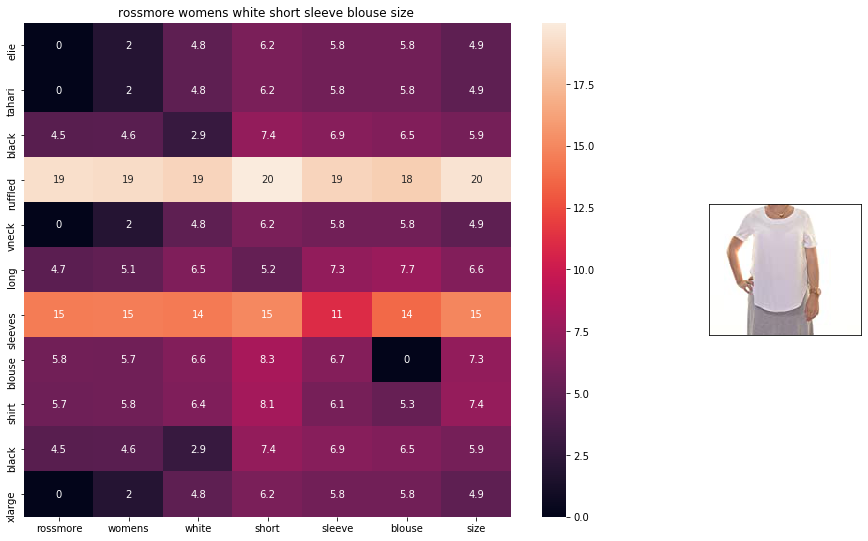

ASIN : B014LKPVC6
Brand : Rossmore
euclidean distance from input : 2.367088


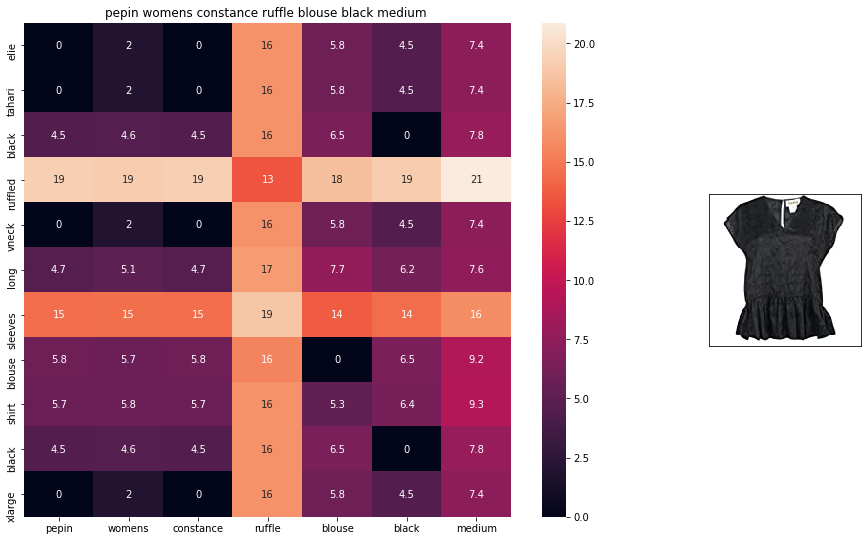

ASIN : B01N5VOV3H
Brand : Pepin
euclidean distance from input : 2.3765607


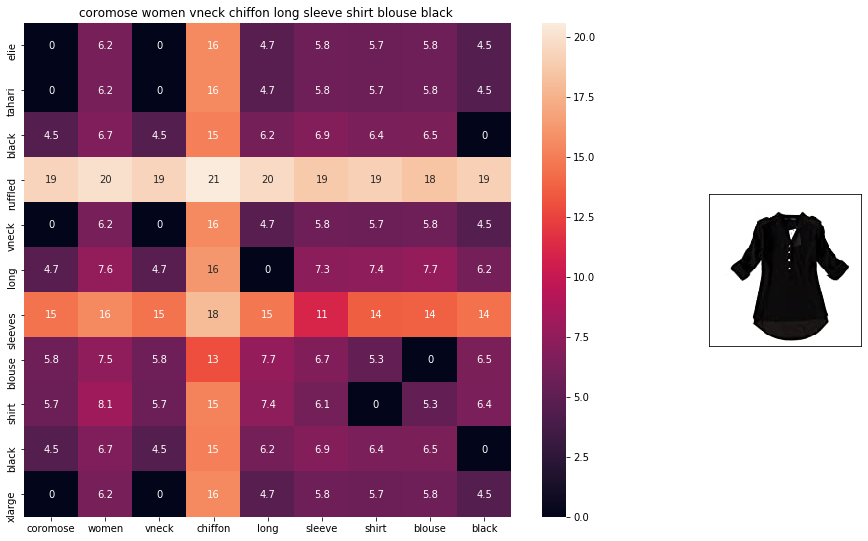

ASIN : B00NNFP22K
Brand : coromose
euclidean distance from input : 2.3785913


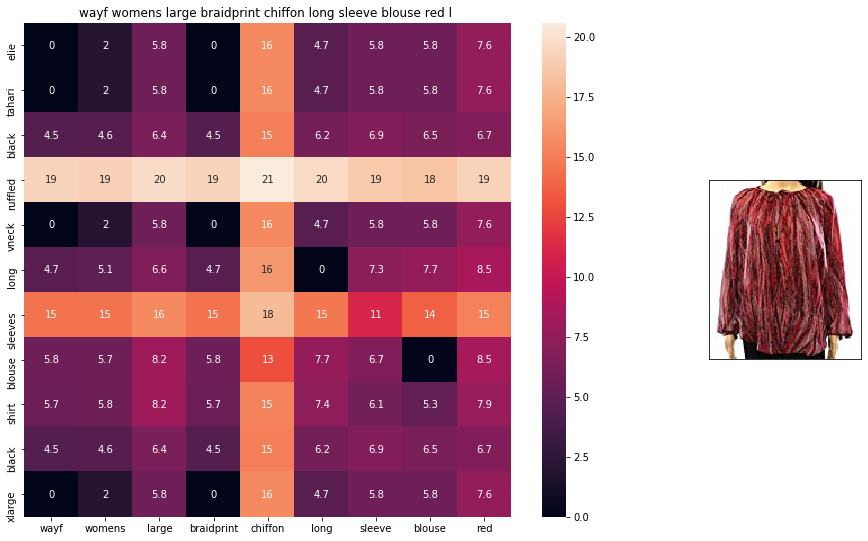

ASIN : B074VD5KCK
Brand : WAYF
euclidean distance from input : 2.3790529


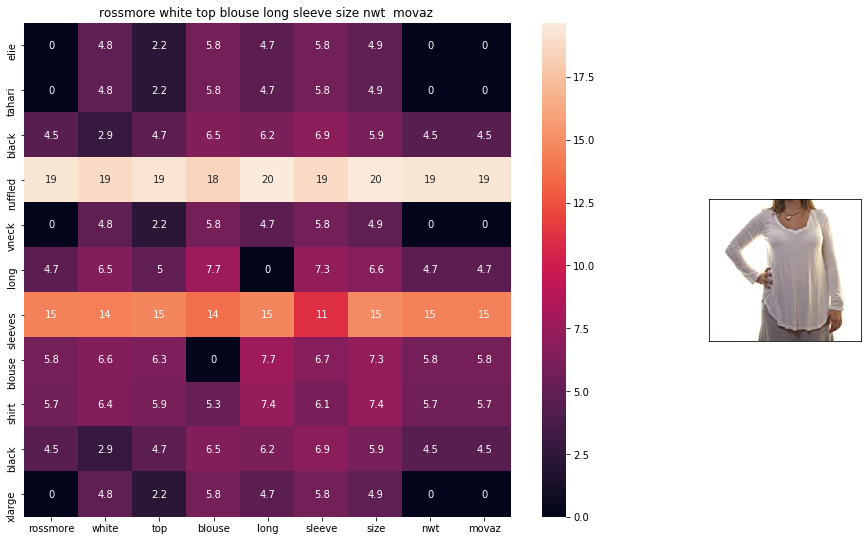

ASIN : B01KIETDV4
Brand : Rossmore
euclidean distance from input : 2.3822951


In [59]:
def weighted_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

weighted_w2v_model(12566, 20)
#931
#12566
# in the give heat map, each cell contains the euclidean distance between words i, j

In [60]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [61]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

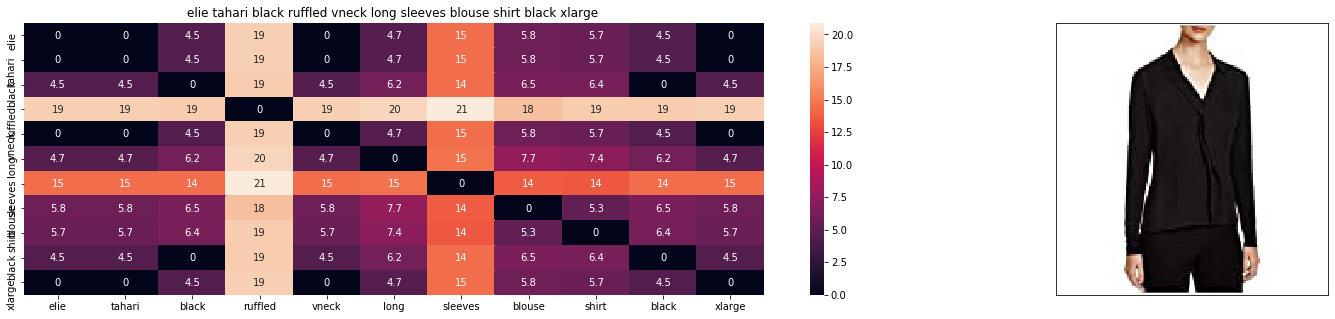

ASIN : B0728DT431
Brand : Elie Tahari
euclidean distance from input : 0.0


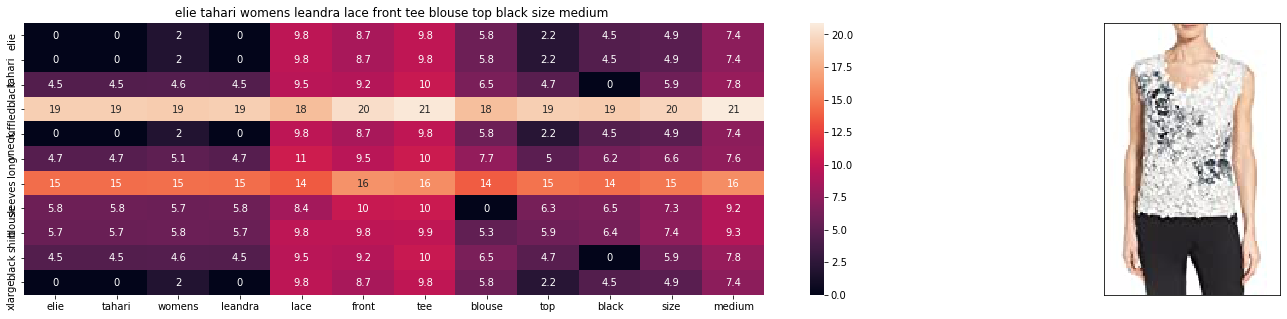

ASIN : B072HMB95W
Brand : Elie Tahari
euclidean distance from input : 1.3228858947753905


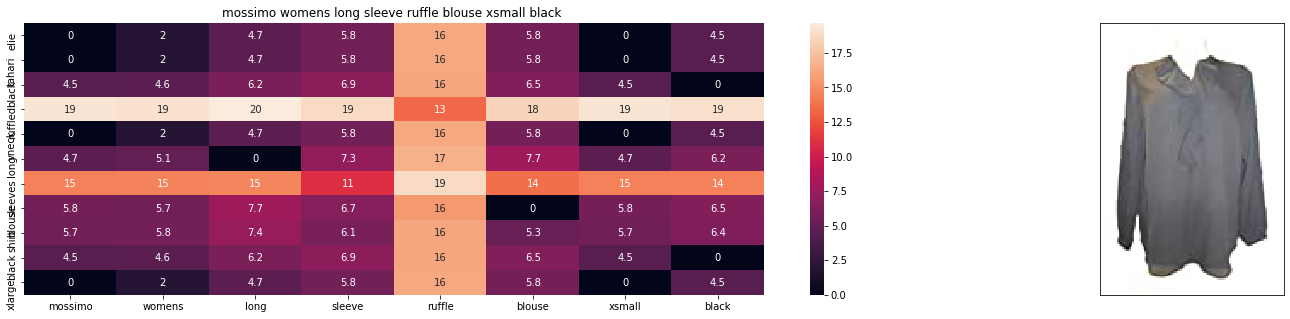

ASIN : B072BGHT28
Brand : Mossimo
euclidean distance from input : 1.7746181047426905


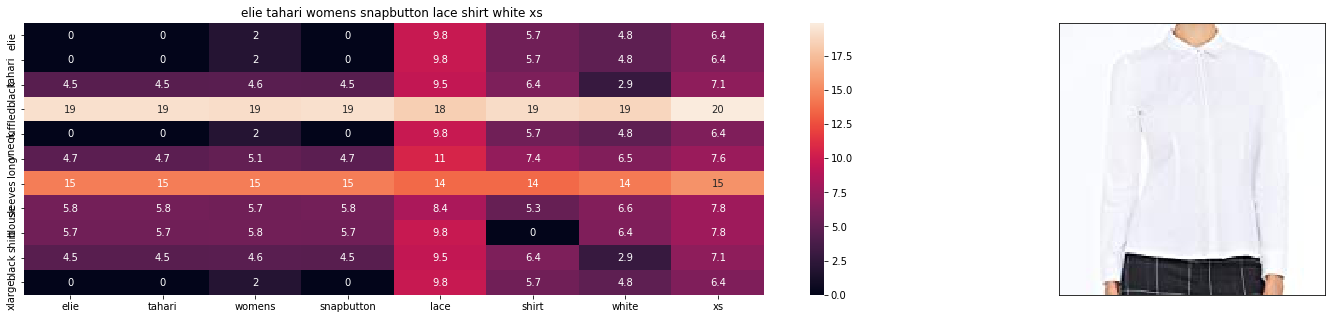

ASIN : B06X8YS632
Brand : Elie Tahari
euclidean distance from input : 1.9286864282507565


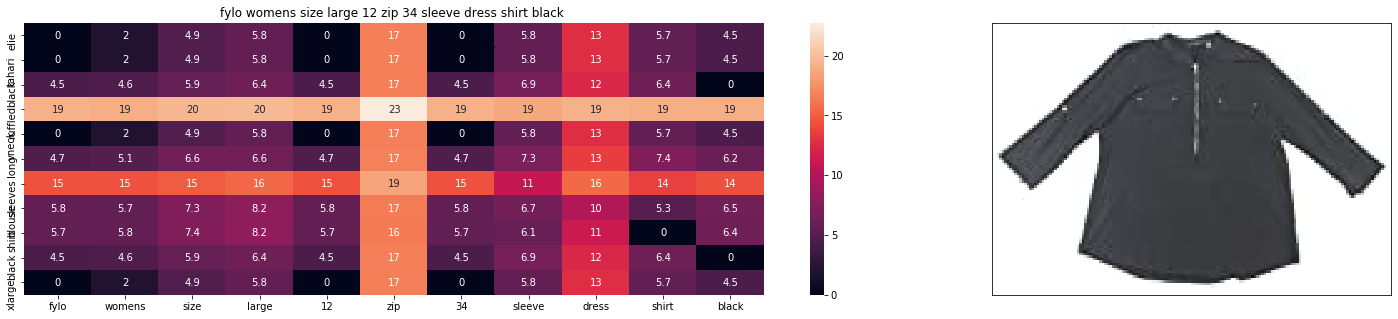

ASIN : B0718Y9J4M
Brand : f
euclidean distance from input : 1.9635807039160398


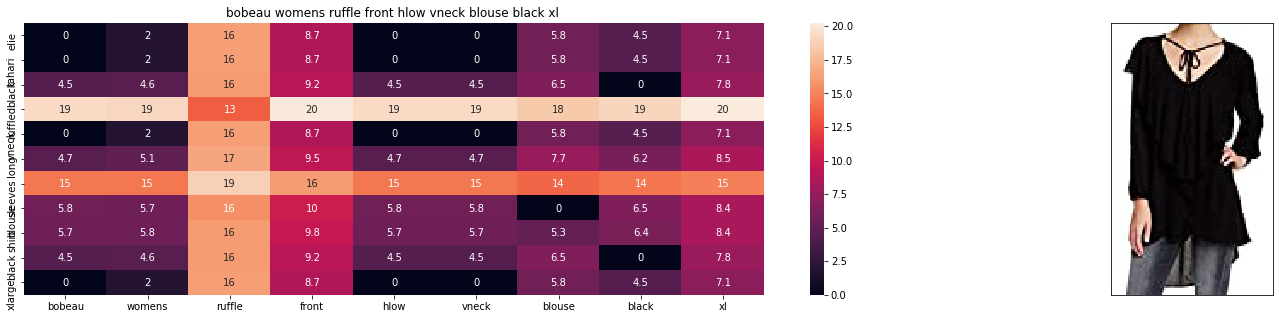

ASIN : B0758J19PY
Brand : Bobeau
euclidean distance from input : 2.0174488580691063


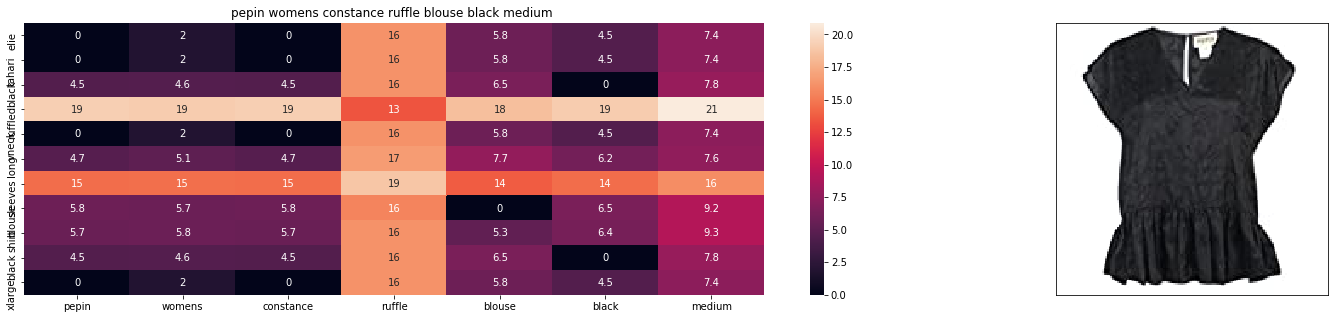

ASIN : B01N5VOV3H
Brand : Pepin
euclidean distance from input : 2.054305700110122


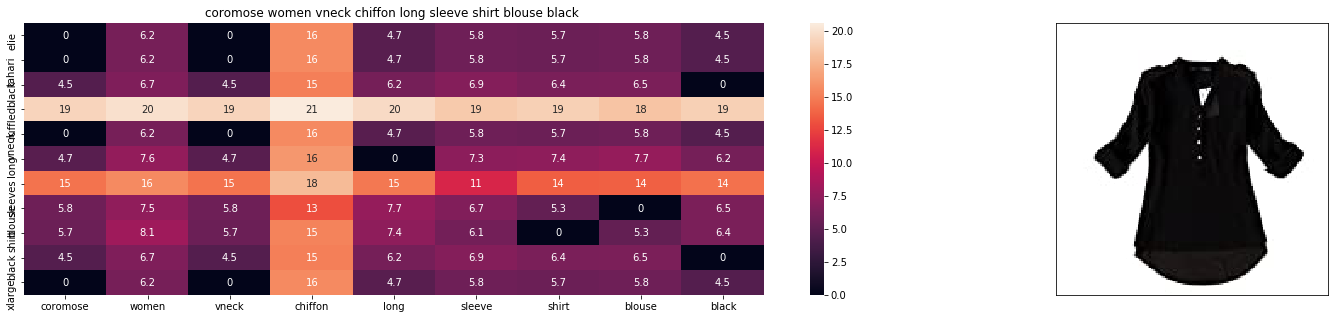

ASIN : B00NNFP22K
Brand : coromose
euclidean distance from input : 2.0553210771548


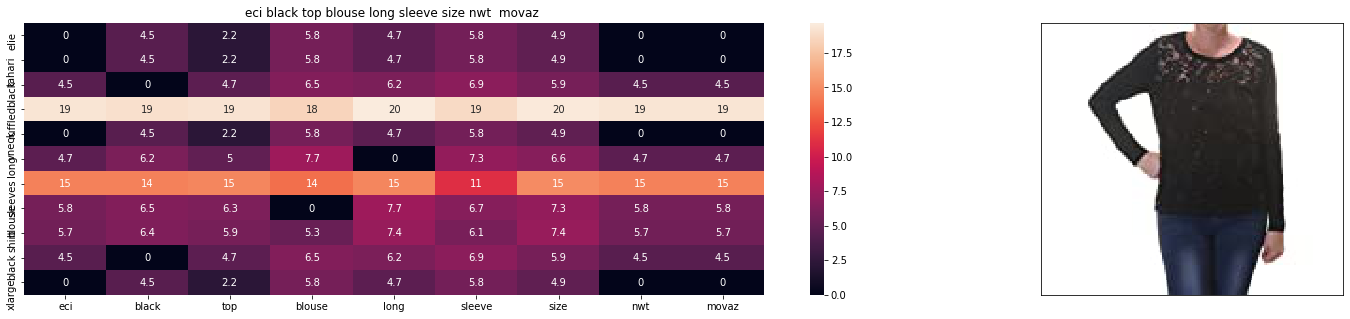

ASIN : B014LAZII8
Brand : ECI
euclidean distance from input : 2.0598507440554346


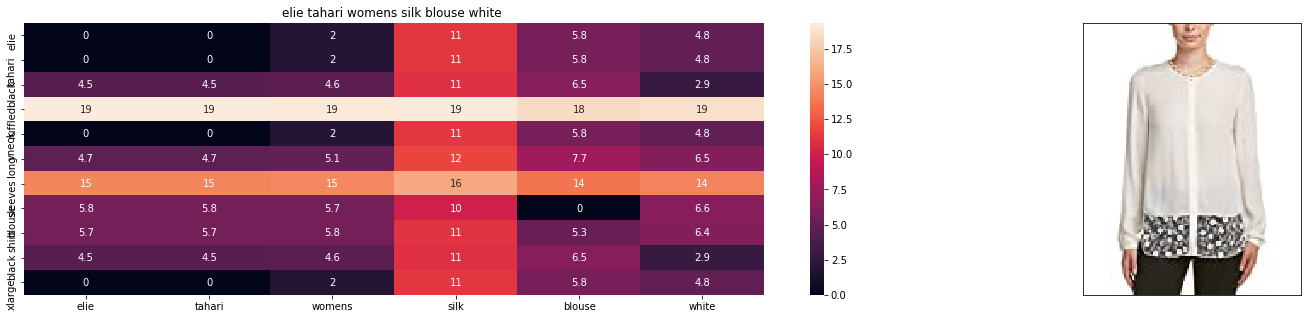

ASIN : B0758ZBV4G
Brand : Elie Tahari
euclidean distance from input : 2.0631447793860103


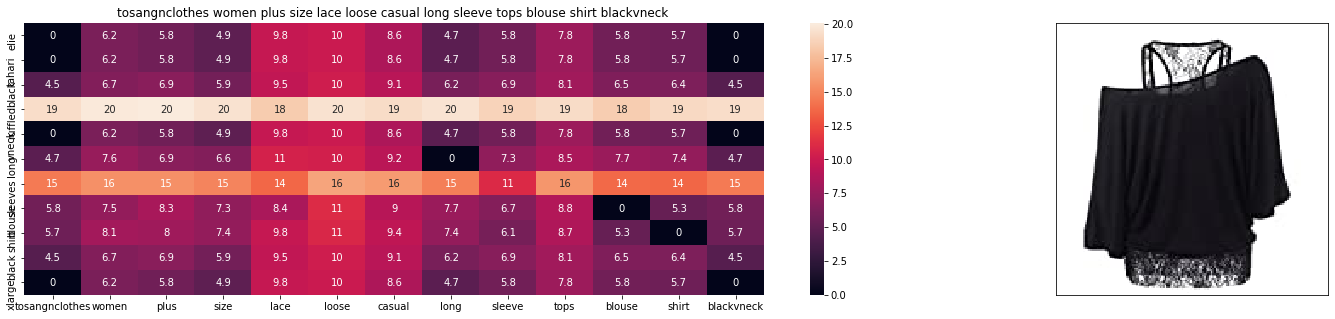

ASIN : B06XFVRWWL
Brand : Tosangn_Clothes
euclidean distance from input : 2.0734133279787743


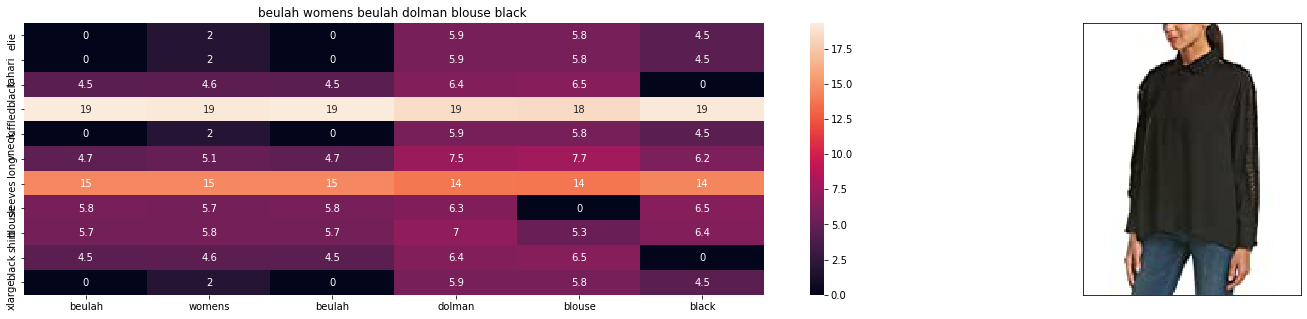

ASIN : B074RNWHL2
Brand : Beulah
euclidean distance from input : 2.0824952638613428


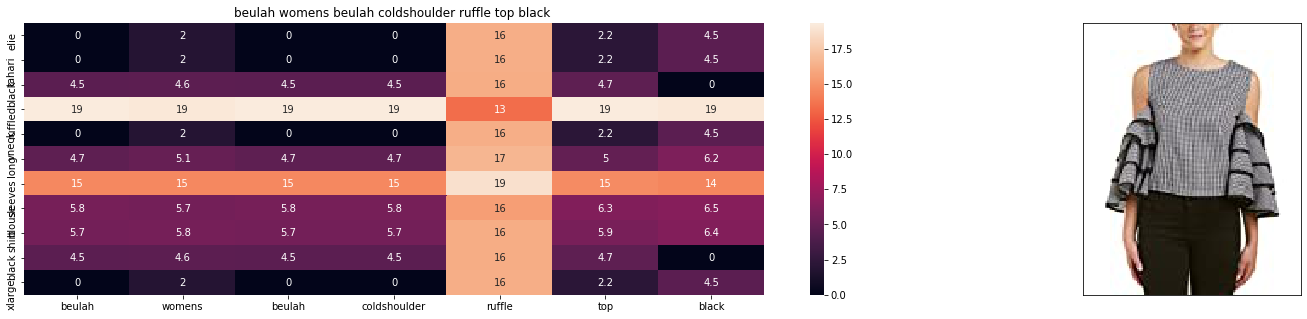

ASIN : B074L993XZ
Brand : Beulah
euclidean distance from input : 2.0919754541384425


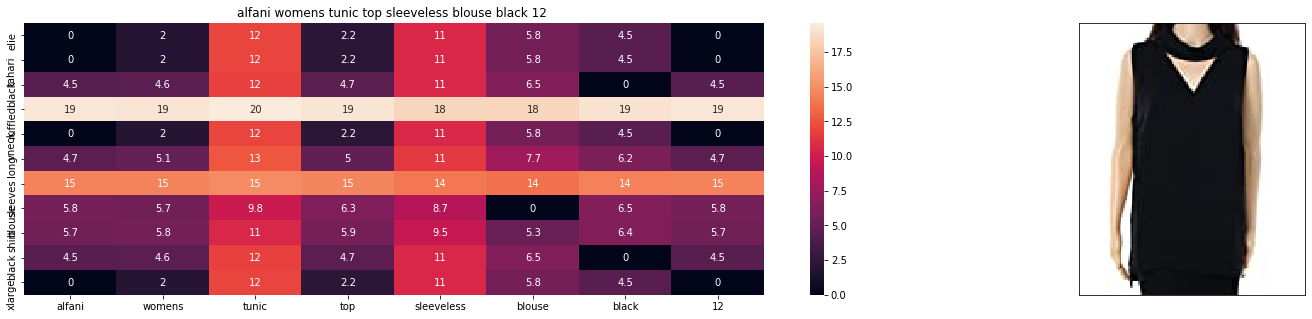

ASIN : B071V8VJJT
Brand : Alfani
euclidean distance from input : 2.12471051578395


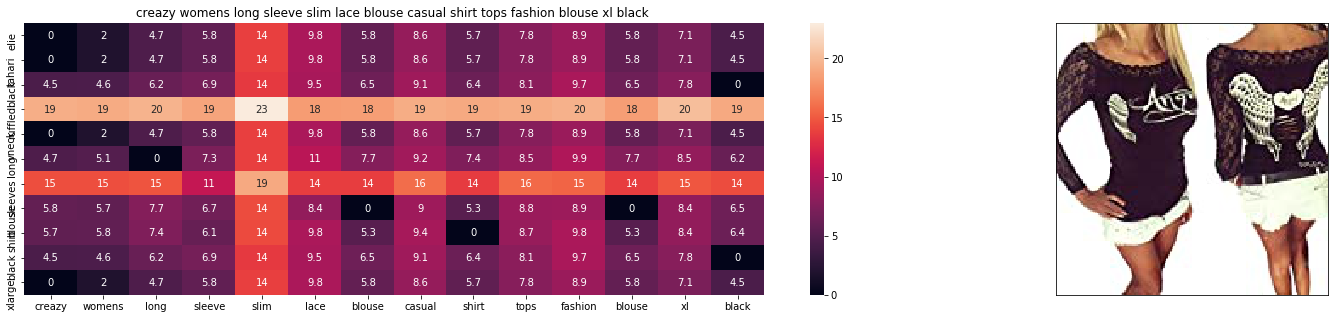

ASIN : B01EV1NKNW
Brand : Creazy
euclidean distance from input : 2.132208112524673


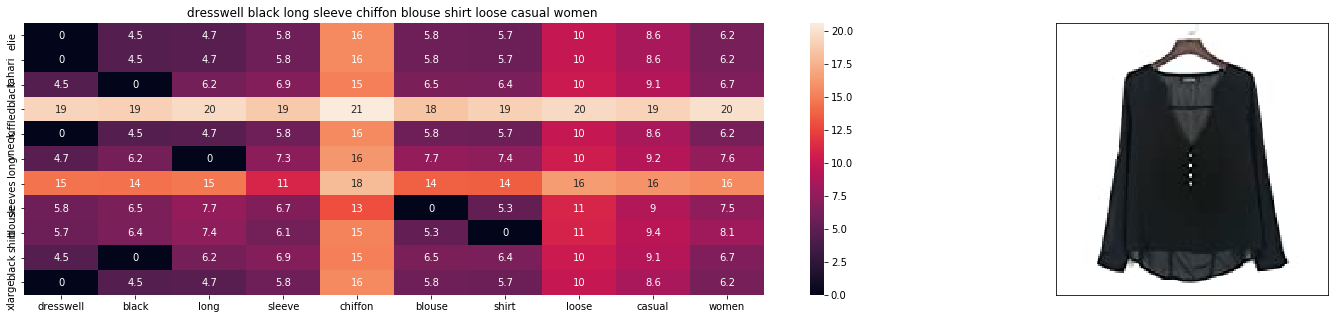

ASIN : B01JS2A3BG
Brand : Dresswell
euclidean distance from input : 2.1398657358156887


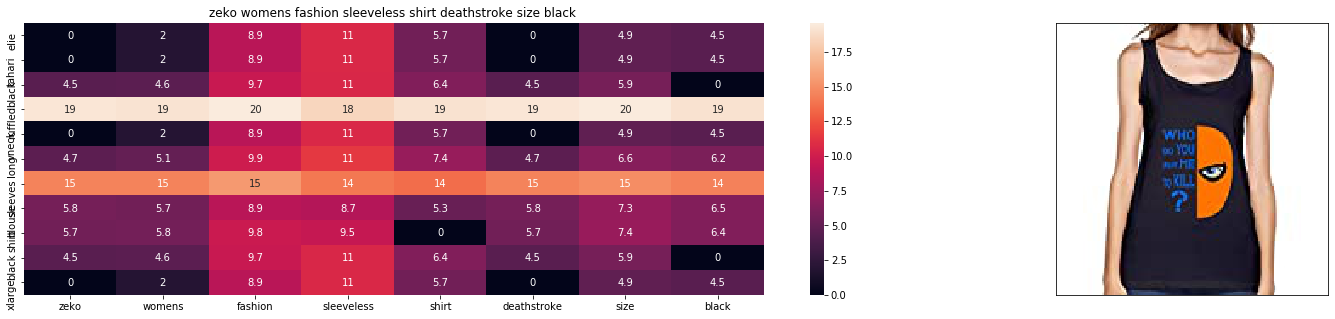

ASIN : B01547U3E6
Brand : ZEKO
euclidean distance from input : 2.1401332414614407


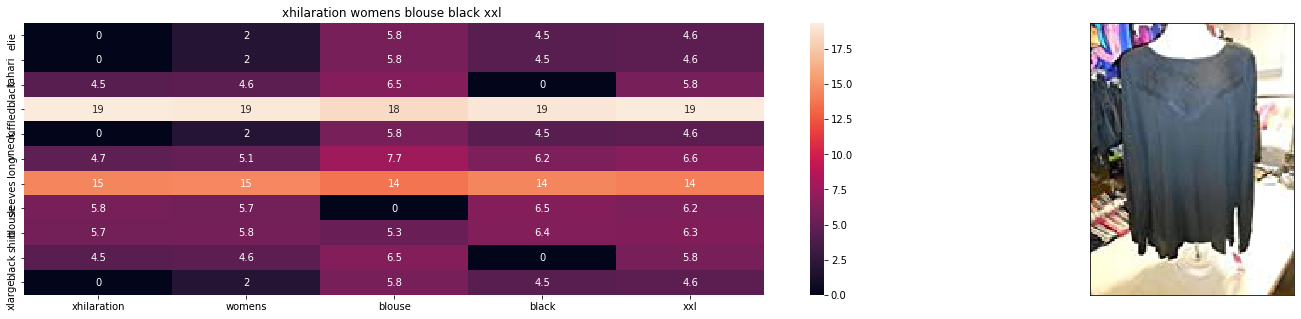

ASIN : B071XT7PGN
Brand : Xhilaration
euclidean distance from input : 2.1426356828676907


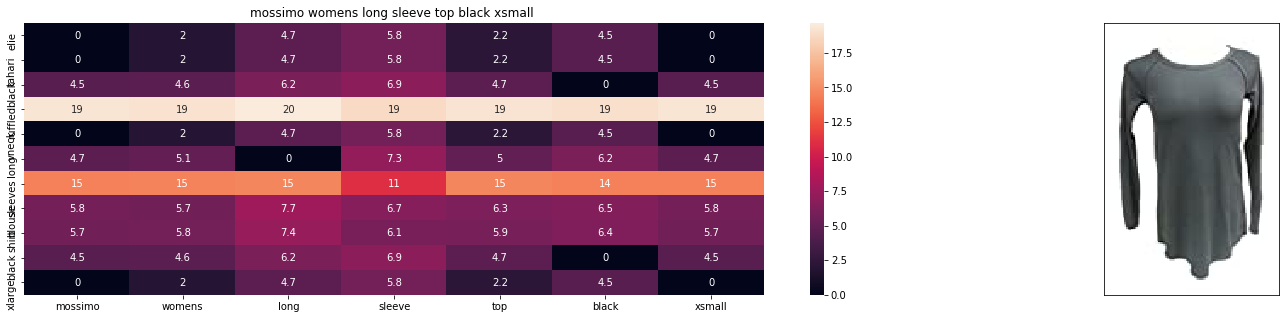

ASIN : B07173L752
Brand : Mossimo
euclidean distance from input : 2.1439379251467434


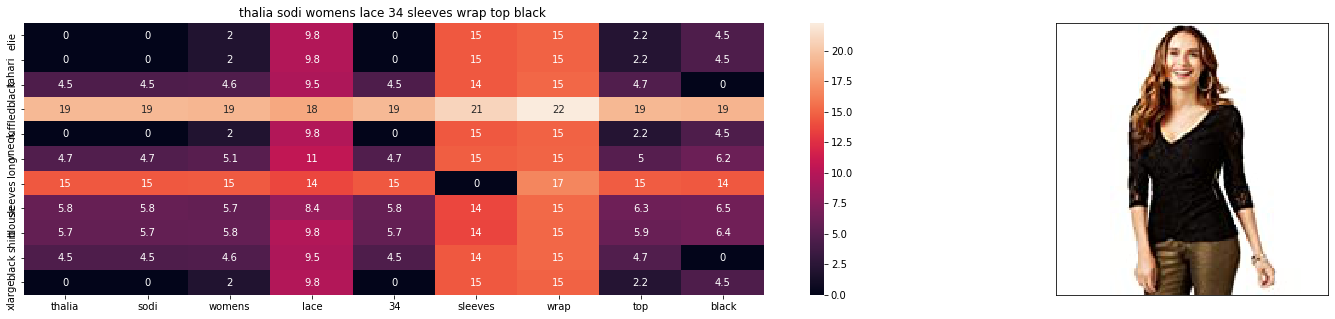

ASIN : B01LW5XRO6
Brand : Thalia
euclidean distance from input : 2.1487383401858056


In [62]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

idf_w2v_brand(12566, 5, 5, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

In [63]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

ModuleNotFoundError: No module named 'keras'

In [68]:
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

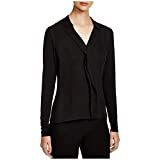

Product Title:  elie tahari black ruffled vneck long sleeves blouse shirt black xlarge 
Euclidean Distance from input image: 5.722046e-06
Amazon Url: www.amzon.com/dp/B0728DT431


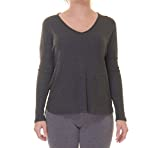

Product Title:  one clothing juniors thermalknit highlow tunic top size xl 
Euclidean Distance from input image: 33.538757
Amazon Url: www.amzon.com/dp/B06XNQ49FN


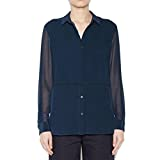

Product Title:  brochu walker womens vera blouse shadow extra small 
Euclidean Distance from input image: 33.828888
Amazon Url: www.amzon.com/dp/B01MZ8SOVU


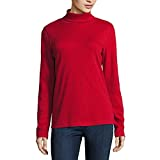

Product Title:  st johns bay long sleeve turtleneck size rumba red 
Euclidean Distance from input image: 34.683544
Amazon Url: www.amzon.com/dp/B06Y45K99H


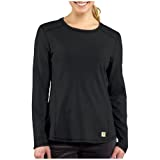

Product Title:  womens carhartt force longsleeved crewneck tulip pink hthr sm 
Euclidean Distance from input image: 35.188572
Amazon Url: www.amzon.com/dp/B00EALU0XW


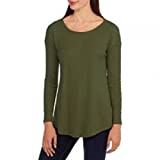

Product Title:  french laundry womens ribbed tunic lace trim olive camo xl 
Euclidean Distance from input image: 35.22221
Amazon Url: www.amzon.com/dp/B06XNJHPDS


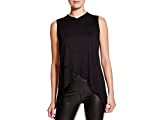

Product Title:  benjamin jay womens slider cross front tank black size small 
Euclidean Distance from input image: 35.279713
Amazon Url: www.amzon.com/dp/B071NBCMLT


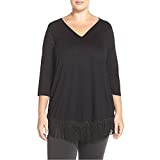

Product Title:  junarose plus size vneck fringe top black 2x 
Euclidean Distance from input image: 35.29977
Amazon Url: www.amzon.com/dp/B00YJ28O8U


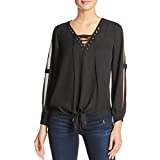

Product Title:  landa dora landa womens georgette lace blouse black 
Euclidean Distance from input image: 35.305943
Amazon Url: www.amzon.com/dp/B0741T7Y2L


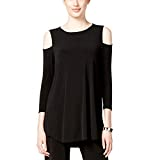

Product Title:  alfani coldshoulder top black medium 
Euclidean Distance from input image: 35.339775
Amazon Url: www.amzon.com/dp/B0741VGRZ7


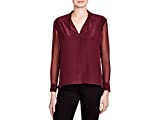

Product Title:  charlie jade womens long sheer sleeve top burgundy size xsmall 
Euclidean Distance from input image: 35.42785
Amazon Url: www.amzon.com/dp/B071HNYH6C


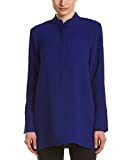

Product Title:  josie natori womens top blue 
Euclidean Distance from input image: 35.483707
Amazon Url: www.amzon.com/dp/B01NBXRIH8


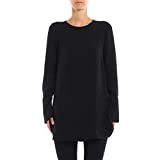

Product Title:  max mara womens alfio silk tunic sz 8 black 
Euclidean Distance from input image: 35.48663
Amazon Url: www.amzon.com/dp/B0749RSMGN


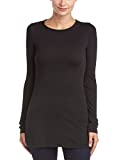

Product Title:  bobi womens bobi sharkbite tunic top xs black 
Euclidean Distance from input image: 35.50697
Amazon Url: www.amzon.com/dp/B01M4NNXXZ


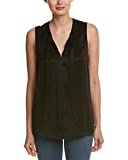

Product Title:  splendid womens tieneck blouse l black 
Euclidean Distance from input image: 35.560513
Amazon Url: www.amzon.com/dp/B0716F4X2L


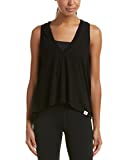

Product Title:  vimmia womens vimmia pacific cowl back tank xl black 
Euclidean Distance from input image: 35.861244
Amazon Url: www.amzon.com/dp/B0717997RX


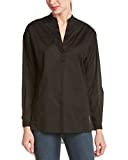

Product Title:  rag  bone womens  jean highlow tunic xxs black 
Euclidean Distance from input image: 36.080498
Amazon Url: www.amzon.com/dp/B06XCZFCWM


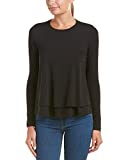

Product Title:  susana monaco womens susana monoco crew neck top xs black 
Euclidean Distance from input image: 36.19855
Amazon Url: www.amzon.com/dp/B0753W3VML


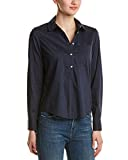

Product Title:  j brand womens pinstripe shirt xs blue 
Euclidean Distance from input image: 36.33792
Amazon Url: www.amzon.com/dp/B06XYP1X1F


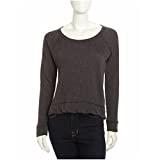

Product Title:  james perse vintage raglan top slate 2  medium 
Euclidean Distance from input image: 36.46025
Amazon Url: www.amzon.com/dp/B01NCOIN8Q


In [69]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo


#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(12566, 20)

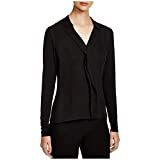

Product Title:  elie tahari black ruffled vneck long sleeves blouse shirt black xlarge 
Euclidean Distance from input image: 5.722046e-06
Amazon Url: www.amzon.com/dp/B0728DT431


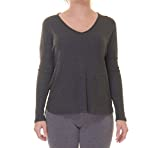

Product Title:  one clothing juniors thermalknit highlow tunic top size xl 
Euclidean Distance from input image: 33.538757
Amazon Url: www.amzon.com/dp/B06XNQ49FN


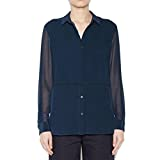

Product Title:  brochu walker womens vera blouse shadow extra small 
Euclidean Distance from input image: 33.828888
Amazon Url: www.amzon.com/dp/B01MZ8SOVU


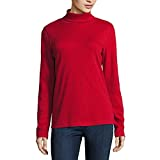

Product Title:  st johns bay long sleeve turtleneck size rumba red 
Euclidean Distance from input image: 34.683544
Amazon Url: www.amzon.com/dp/B06Y45K99H


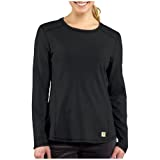

Product Title:  womens carhartt force longsleeved crewneck tulip pink hthr sm 
Euclidean Distance from input image: 35.188572
Amazon Url: www.amzon.com/dp/B00EALU0XW


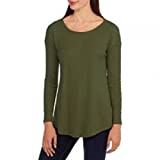

Product Title:  french laundry womens ribbed tunic lace trim olive camo xl 
Euclidean Distance from input image: 35.22221
Amazon Url: www.amzon.com/dp/B06XNJHPDS


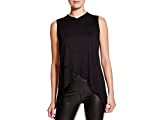

Product Title:  benjamin jay womens slider cross front tank black size small 
Euclidean Distance from input image: 35.279713
Amazon Url: www.amzon.com/dp/B071NBCMLT


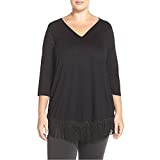

Product Title:  junarose plus size vneck fringe top black 2x 
Euclidean Distance from input image: 35.29977
Amazon Url: www.amzon.com/dp/B00YJ28O8U


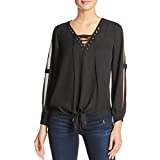

Product Title:  landa dora landa womens georgette lace blouse black 
Euclidean Distance from input image: 35.305943
Amazon Url: www.amzon.com/dp/B0741T7Y2L


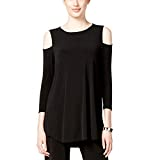

Product Title:  alfani coldshoulder top black medium 
Euclidean Distance from input image: 35.339775
Amazon Url: www.amzon.com/dp/B0741VGRZ7


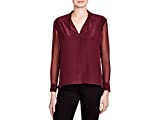

Product Title:  charlie jade womens long sheer sleeve top burgundy size xsmall 
Euclidean Distance from input image: 35.42785
Amazon Url: www.amzon.com/dp/B071HNYH6C


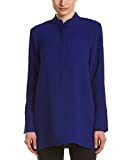

Product Title:  josie natori womens top blue 
Euclidean Distance from input image: 35.483707
Amazon Url: www.amzon.com/dp/B01NBXRIH8


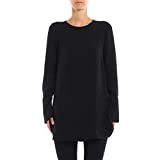

Product Title:  max mara womens alfio silk tunic sz 8 black 
Euclidean Distance from input image: 35.48663
Amazon Url: www.amzon.com/dp/B0749RSMGN


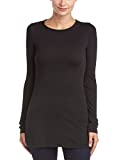

Product Title:  bobi womens bobi sharkbite tunic top xs black 
Euclidean Distance from input image: 35.50697
Amazon Url: www.amzon.com/dp/B01M4NNXXZ


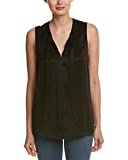

Product Title:  splendid womens tieneck blouse l black 
Euclidean Distance from input image: 35.560513
Amazon Url: www.amzon.com/dp/B0716F4X2L


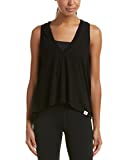

Product Title:  vimmia womens vimmia pacific cowl back tank xl black 
Euclidean Distance from input image: 35.861244
Amazon Url: www.amzon.com/dp/B0717997RX


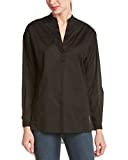

Product Title:  rag  bone womens  jean highlow tunic xxs black 
Euclidean Distance from input image: 36.080498
Amazon Url: www.amzon.com/dp/B06XCZFCWM


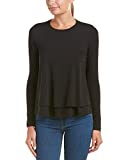

Product Title:  susana monaco womens susana monoco crew neck top xs black 
Euclidean Distance from input image: 36.19855
Amazon Url: www.amzon.com/dp/B0753W3VML


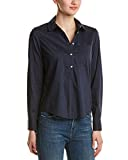

Product Title:  j brand womens pinstripe shirt xs blue 
Euclidean Distance from input image: 36.33792
Amazon Url: www.amzon.com/dp/B06XYP1X1F


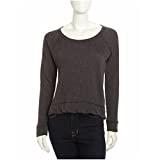

Product Title:  james perse vintage raglan top slate 2  medium 
Euclidean Distance from input image: 36.46025
Amazon Url: www.amzon.com/dp/B01NCOIN8Q


In [70]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo


#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(12566, 20)